In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np

from utils.conn_data import load_pickle
from utils.diagnostics import compute_summary_statistics

plt.style.use('ggplot')

In [2]:
inputs_path = os.path.join(os.getcwd(), "data", "inputs")
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
forecast_input = "wrds_etf_returns"
memory_input = "fredmd_transf"
vol_target = 0.15
portfolio_methods = [
    "naive",
    #"weighted-naive",
    "linear-ridge",
    "mvo",
    "bl"
]

In [3]:
# load memory data and preprocess
memory_data = pd.read_csv(os.path.join(inputs_path, f'{memory_input}.csv'))

## fix dates
memory_data["date"] = pd.to_datetime(memory_data["date"])
memory_data = memory_data.set_index("date")
memory_data = memory_data.astype(float)

# fill missing values
memory_data = memory_data.interpolate(method='linear', limit_direction='forward', axis=0)
memory_data = memory_data.ffill()
memory_data = memory_data.bfill()

## compute moving average
memory_data = memory_data.rolling(window=12).mean()

## drop missing values
memory_data = memory_data.dropna()

returns = pd.read_csv(os.path.join(inputs_path, f'{forecast_input}.csv'))
returns = returns[[col for col in returns.columns if "t+1" not in col]]

## fix dates
returns["date"] = pd.to_datetime(returns["date"])
returns["date"] = returns["date"] #+ pd.DateOffset(months=1)
returns = returns.set_index("date")
memory_data = memory_data.astype(float)

## resample and match memory data dates
returns = returns.resample("MS").last().ffill()
returns = pd.merge(returns, memory_data[[memory_data.columns[0]]], left_index=True, right_index=True).drop(memory_data.columns[0], axis=1)

## drop missing values
returns = returns.dropna()

In [4]:
import numpy as np
import pandas as pd

data_factors = pd.read_csv('data/inputs/fredmd_factors_raw.csv')
transformation_codes = data_factors.iloc[0]
data_factors = data_factors.drop(0)
transformation_codes = transformation_codes.to_dict()
del transformation_codes['sasdate']

small = 1e-6
for column in data_factors.columns:
    if column in transformation_codes:
        match int(transformation_codes[column]):
            case 1:
                data_factors[column] = data_factors[column]

            case 2: # First difference: x(t)-x(t-1)
                data_factors[column] = data_factors[column].diff()

            case 3: # Second difference: (x(t)-x(t-1))-(x(t-1)-x(t-2))
                data_factors[column] = data_factors[column].diff().diff()

            case 4: # Natural log: ln(x)
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)

            case 5: # First difference of natural log: ln(x)-ln(x-1)
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)
                data_factors[column] = data_factors[column].diff()

            case 6: # Second difference of natural log: (ln(x)-ln(x-1))-(ln(x-1)-ln(x-2))
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)
                data_factors[column] = data_factors[column].diff().diff()

            case 7: # First difference of percent change: (x(t)/x(t-1)-1)-(x(t-1)/x(t-2)-1)
                data_factors[column] = data_factors[column].pct_change()
                data_factors[column] = data_factors[column].diff()

data_factors = data_factors.drop([1, 2]).reset_index(drop=True)

data_factors = data_factors.ffill()
data_factors = data_factors.fillna(0.0)

data_factors['sasdate'] = pd.to_datetime(data_factors['sasdate'], format='%m/%d/%Y')
data_factors = data_factors.rename(columns={'sasdate': 'date'})
data_factors = data_factors.set_index('date')


from sklearn.decomposition import PCA
import matplotlib.pyplot as plot

df_normalized = data_factors

# You must normalize the data before applying the fit method
df_normalized=(df_normalized - df_normalized.mean()) / df_normalized.std()
pca = PCA(n_components=df_normalized.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df_normalized.columns)
print(loadings)

DESIRE_EXPLAINED_VARIANCE = 0.95
total_explained_variance = 0.0
for i, x in enumerate(pca.explained_variance_ratio_):
    total_explained_variance += x
    if total_explained_variance >= DESIRE_EXPLAINED_VARIANCE:
        print(f"Number of components to explain {DESIRE_EXPLAINED_VARIANCE * 100}% variance: {i+1}")
        break
n_components = i+1

# Use the top n components to transform the data
pca = PCA(n_components=df_normalized.shape[1])
pca.fit(df_normalized)
df_transformed = pd.DataFrame(pca.transform(df_normalized),
columns=['PC%s' % _ for _ in range(df_normalized.shape[1])],
index=df_normalized.index)
df_transformed = df_transformed[['PC%s' % _ for _ in range(n_components)]]

print(df_transformed)

memory_data = df_transformed

                      PC0       PC1       PC2       PC3       PC4       PC5  \
RPI              0.032678 -0.047984  0.000752 -0.025343  0.063781 -0.045892   
W875RX1         -0.112550 -0.068211 -0.038119  0.032999  0.006149  0.006541   
DPCERA3M086SBEA -0.146550  0.027131 -0.060616  0.042417 -0.018647 -0.143320   
CMRMTSPLx       -0.135673 -0.008126 -0.053135  0.014012  0.024570 -0.093309   
RETAILx         -0.127633  0.065554 -0.019088  0.035344  0.000766 -0.146614   
...                   ...       ...       ...       ...       ...       ...   
UMCSENTx        -0.037855  0.012142 -0.030014 -0.014400 -0.012411 -0.098975   
DTCOLNVHFNM     -0.002451  0.009939  0.011267 -0.016205 -0.015283 -0.058104   
DTCTHFNM        -0.006255  0.013653  0.012419 -0.018355 -0.013001 -0.032122   
INVEST          -0.015517  0.016652 -0.007961  0.011221 -0.015233  0.019285   
VIXCLSx          0.052323  0.001555  0.009238  0.039914 -0.001340 -0.121704   

                      PC6       PC7       PC8      

In [5]:
# get regimes
#memory_dir_name = "kmeans_elbow"
memory_dir_name = 'kmeans'
memory_results_path = os.path.join("data", "inputs", "memory", memory_dir_name, "results_manual_3_elbow.pkl")
memory_results = pd.read_pickle(memory_results_path)
regimes = memory_results["regimes"]
centroids = memory_results["centroids"]
regimes_probs = memory_results["regimes_probs"]

In [6]:
pd.DataFrame(memory_data.columns)

0
0    PC0
1    PC1
2    PC2
3    PC3
4    PC4
..   ...
56  PC56
57  PC57
58  PC58
59  PC59
60  PC60

[61 rows x 1 columns]

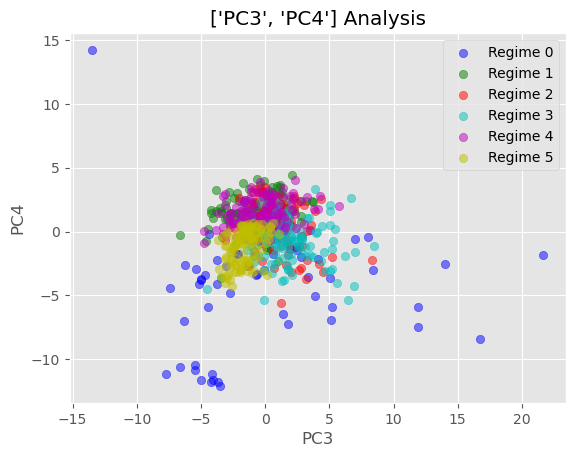

In [18]:
etfs = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
macro_vars = ['PC3', 'PC4']

plt.clf()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i in range(6):
    plt.scatter(memory_data[macro_vars[0]][:-1][regimes['cluster_step697'] == i], memory_data[macro_vars[1]][:-1][regimes['cluster_step697'] == i], c=colors[i], label=f"Regime {i}", alpha=0.5)
plt.title(f"{macro_vars} Analysis")
plt.xlabel(macro_vars[0])
plt.ylabel(macro_vars[1])
plt.legend()
plt.show()

In [7]:
etfs = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
macro_var = 'PC0'

for etf in etfs:
    plt.clf()
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    for i in range(6):
        plt.scatter(memory_data[-276:-1][macro_var][regimes[-275:]['cluster_step697'] == i], returns[etf][regimes[-275:]['cluster_step697'] == i], c=colors[i], label=f"Regime {i}", alpha=0.5)
    plt.title(f"{etf} / {macro_var} Analysis")
    plt.xlabel(macro_var)
    plt.ylabel(etf + " Returns")
    plt.legend()
    plt.show()

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

<Figure size 640x480 with 0 Axes>

In [6]:
all_portfolio_returns = []
colors = ['r', 'b', 'g', 'y', 'm', 'c', 'k']
line_types = ['-', '--', '-.', ':']
styles = ['m', 'c']
style_map = {}
for method in portfolio_methods:
    print(method)
    cur_color = colors.pop(0)
    dirs = os.listdir(os.path.join(outputs_path, method))

    for i, dir in enumerate(dirs):
        cur_line_type = line_types[i % len(line_types)]
        styles.append(f"{cur_color}{cur_line_type}")
        style_map[method + dir.split('/')[-1][7:-4]] = f"{cur_color}{cur_line_type}"
        print(method, dir)

        try:
            results = load_pickle(os.path.join(outputs_path, method, dir))
        except:
            print(method, dir)
            continue

        # get forecasts
        forecasts = results['forecasts']
        forecasts.index = pd.to_datetime(forecasts.index)
        forecasts.index.name = "date"

        # check which dataframe haas the smallest number of rows and match dates
        if len(forecasts) < len(returns):
            returns = returns.loc[forecasts.index[0]:forecasts.index[-1]]
        else:
            forecasts = forecasts.loc[returns.index[0]:returns.index[-1]]

        # match columns
        forecasts = forecasts[returns.columns]

        # portfolio returns
        portfolio_returns = forecasts.multiply(returns, axis=0)

        model_tag = dir.split('.')[0][8:]
        #long_only_tag = dir.split('.')[0].split('_')[1]
        #num_assets_tag = dir.split('.')[0].split('_')[2]
        portfolio_returns["models"] = f"{method}_{model_tag}"

        all_portfolio_returns.append(portfolio_returns.reset_index().melt(["models", "date"]))
all_portfolio_returns_df = pd.concat(all_portfolio_returns)

naive
naive results_los_3_rand.pkl
naive results_mx_4.pkl
naive results_los_3.pkl
naive results_lns_3_rand.pkl
naive results_lns_2.pkl
naive results_mx_3.pkl
naive results_lns_3.pkl
naive results_mx_2.pkl
naive results_los_2.pkl
naive results_lo_2.pkl
naive results_mx_3_rand.pkl
naive results_lns_4.pkl
naive results_lo_3_rand.pkl
naive results_lo_3.pkl
naive results_los_4.pkl
naive results_lo_4.pkl
linear-ridge
linear-ridge results_mx_4.pkl
linear-ridge results_los_3.pkl
linear-ridge results_lns_2.pkl
linear-ridge results_mx_3.pkl
linear-ridge results_lns_3.pkl
linear-ridge results_mx_2.pkl
linear-ridge results_los_2.pkl
linear-ridge results_lo_2.pkl
linear-ridge results_lns_4.pkl
linear-ridge results_lo_3.pkl
linear-ridge results_los_4.pkl
linear-ridge results_lo_4.pkl
mvo
mvo results_lns_2.pkl
mvo results_mx_2.pkl
mvo results_los_2.pkl
mvo results_lo_2.pkl
bl
bl results_lns_2.pkl
bl results_lo_2.pkl
bl results_lns_4.pkl
bl results_lo_4.pkl


{'naive_los_3_rand': 'r-', 'naive_mx_4': 'r--', 'naive_los_3': 'r-.', 'naive_lns_3_rand': 'r:', 'naive_lns_2': 'r-', 'naive_mx_3': 'r--', 'naive_lns_3': 'r-.', 'naive_mx_2': 'r:', 'naive_los_2': 'r-', 'naive_lo_2': 'r--', 'naive_mx_3_rand': 'r-.', 'naive_lns_4': 'r:', 'naive_lo_3_rand': 'r-', 'naive_lo_3': 'r--', 'naive_los_4': 'r-.', 'naive_lo_4': 'r:', 'linear-ridge_mx_4': 'b-', 'linear-ridge_los_3': 'b--', 'linear-ridge_lns_2': 'b-.', 'linear-ridge_mx_3': 'b:', 'linear-ridge_lns_3': 'b-', 'linear-ridge_mx_2': 'b--', 'linear-ridge_los_2': 'b-.', 'linear-ridge_lo_2': 'b:', 'linear-ridge_lns_4': 'b-', 'linear-ridge_lo_3': 'b--', 'linear-ridge_los_4': 'b-.', 'linear-ridge_lo_4': 'b:', 'mvo_lns_2': 'g-', 'mvo_mx_2': 'g--', 'mvo_los_2': 'g-.', 'mvo_lo_2': 'g:', 'bl_lns_2': 'y-', 'bl_lo_2': 'y--', 'bl_lns_4': 'y-.', 'bl_lo_4': 'y:'}


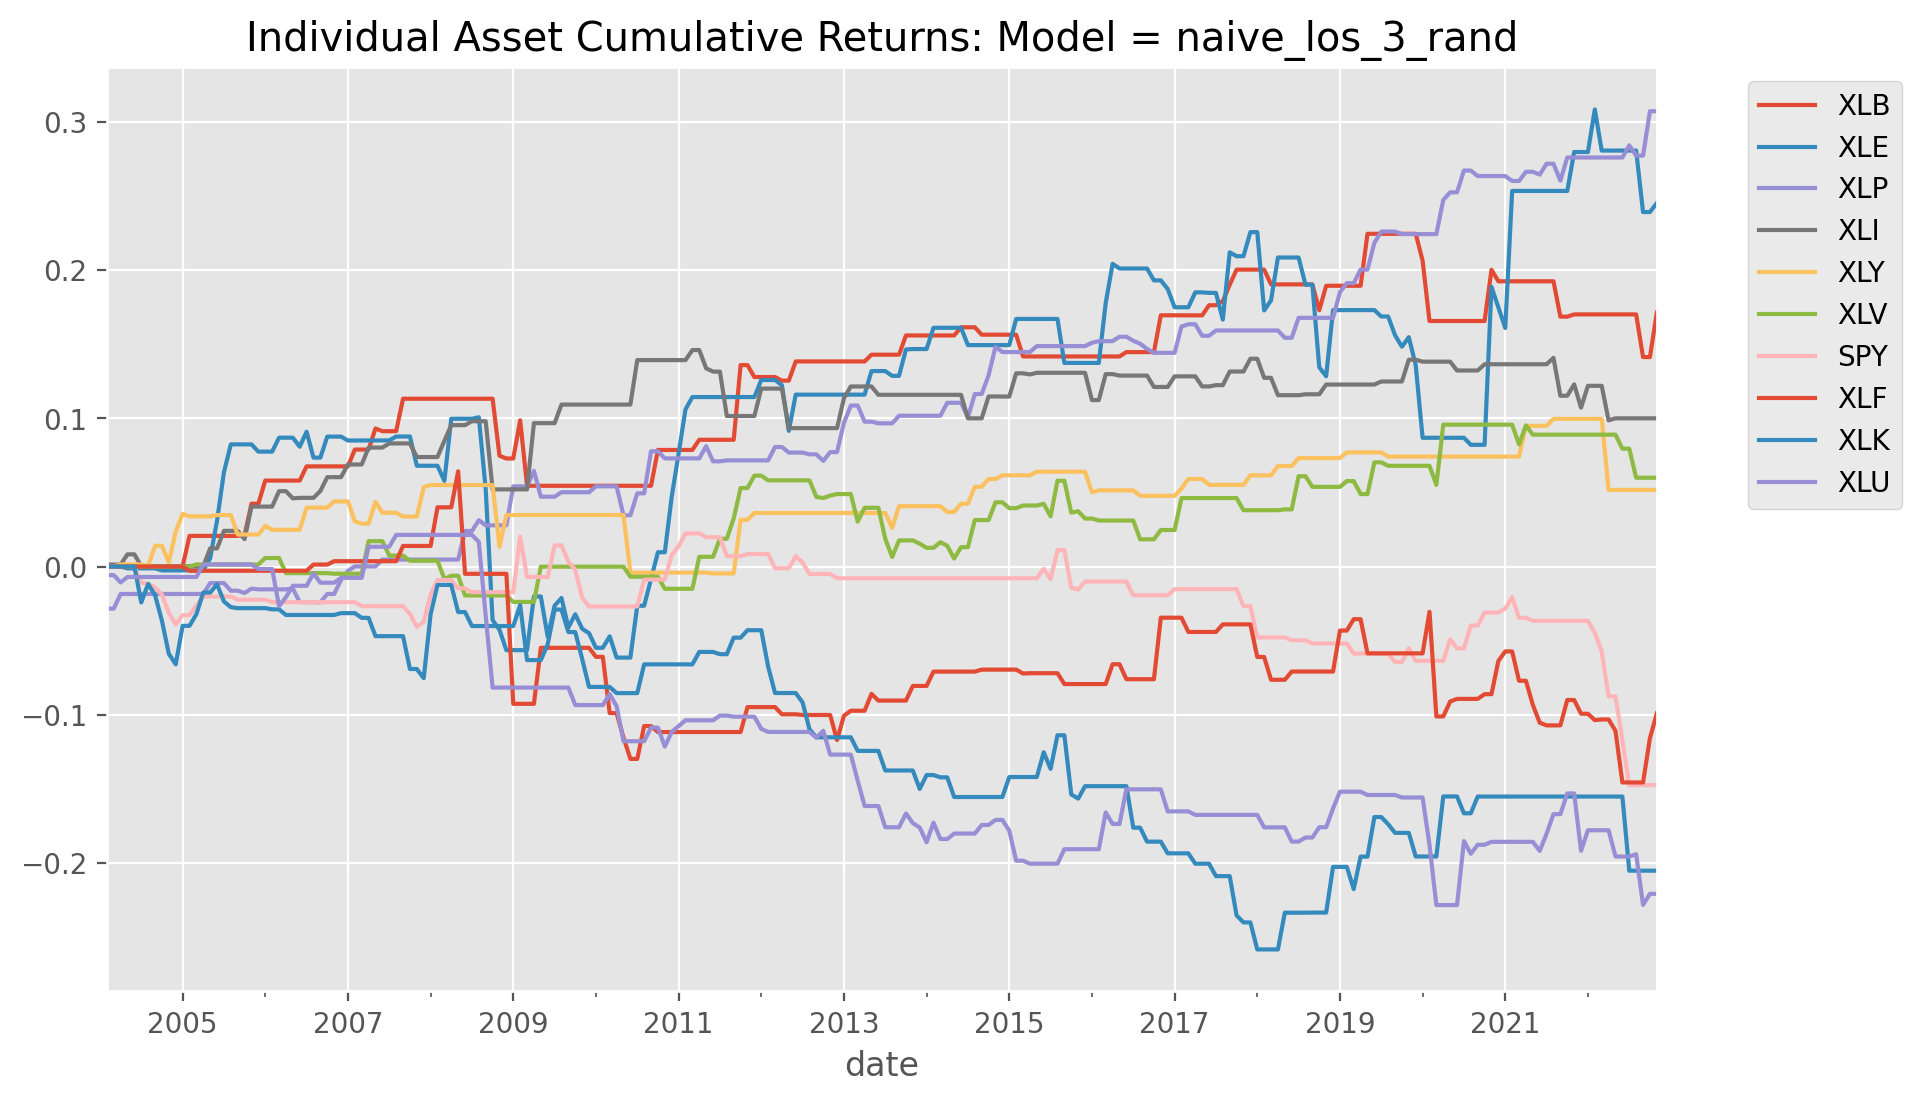

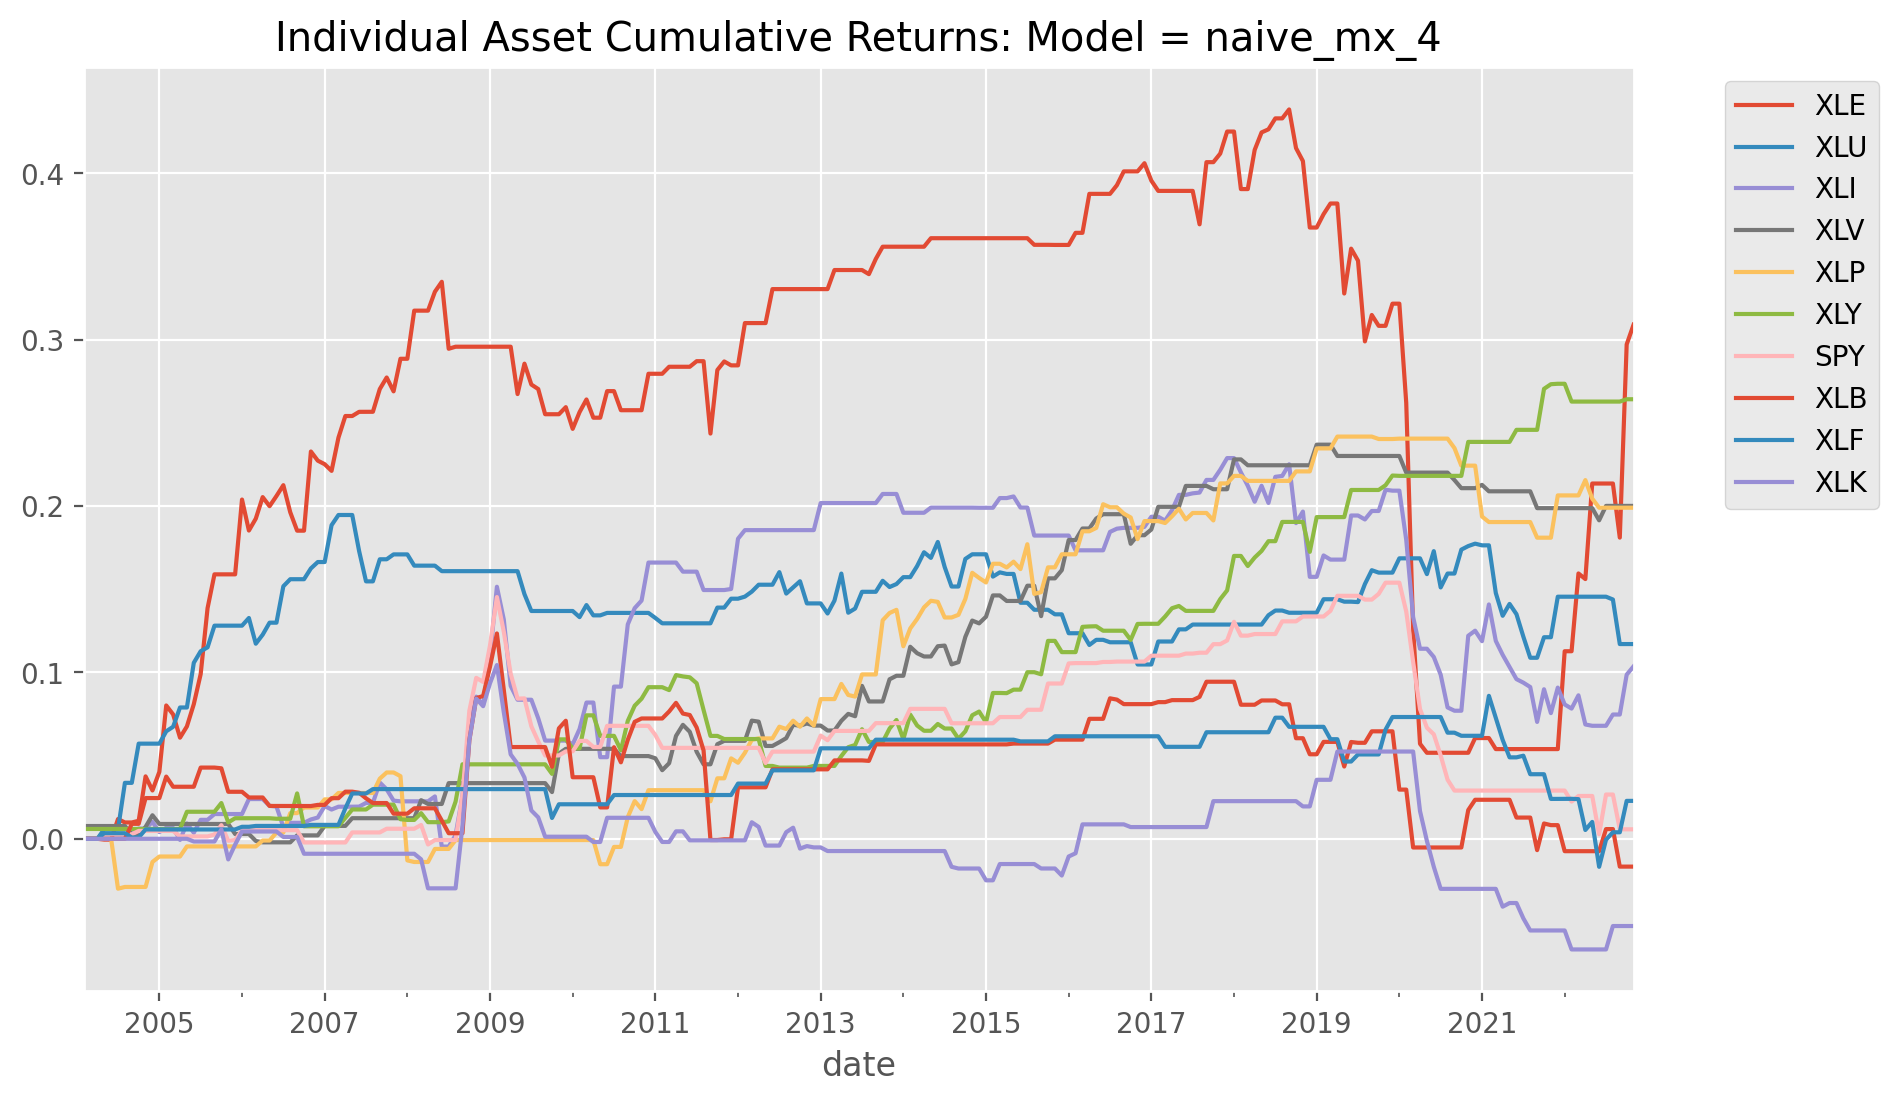

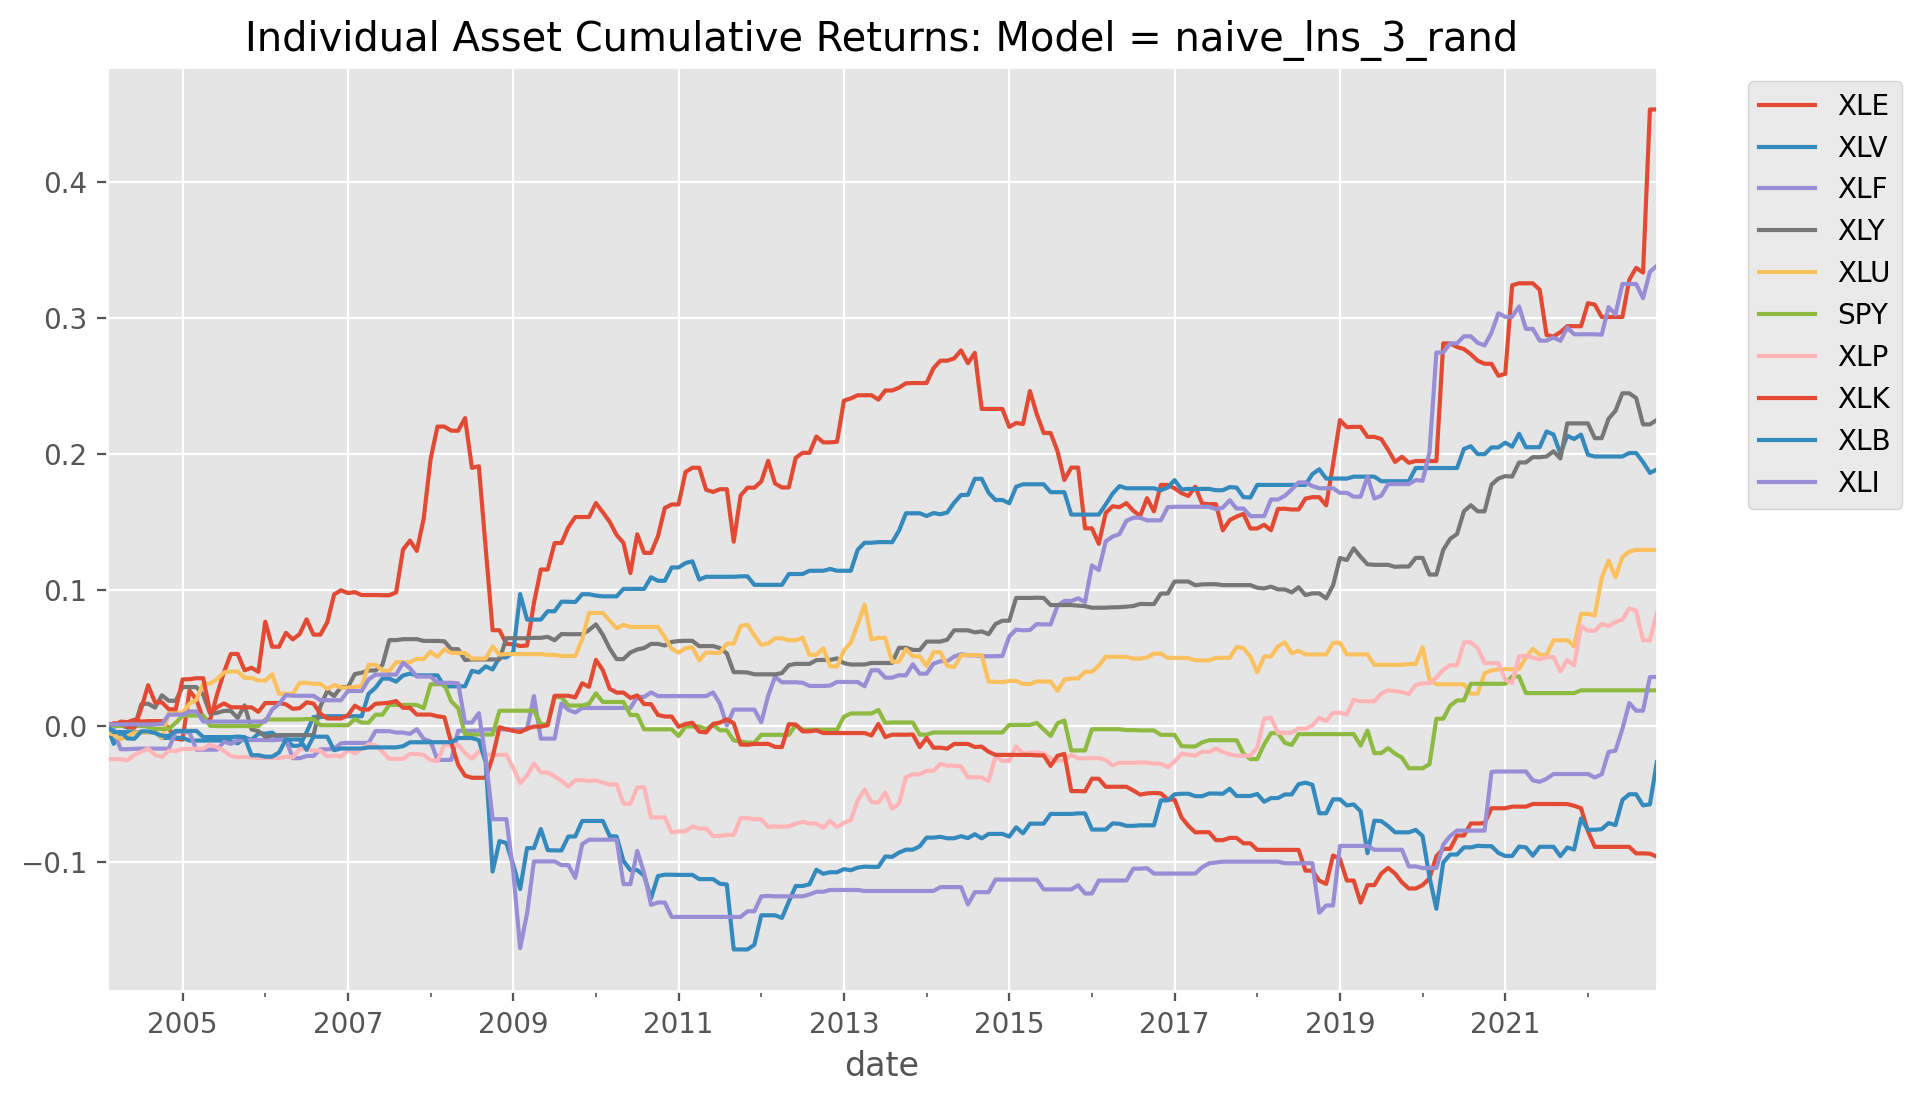

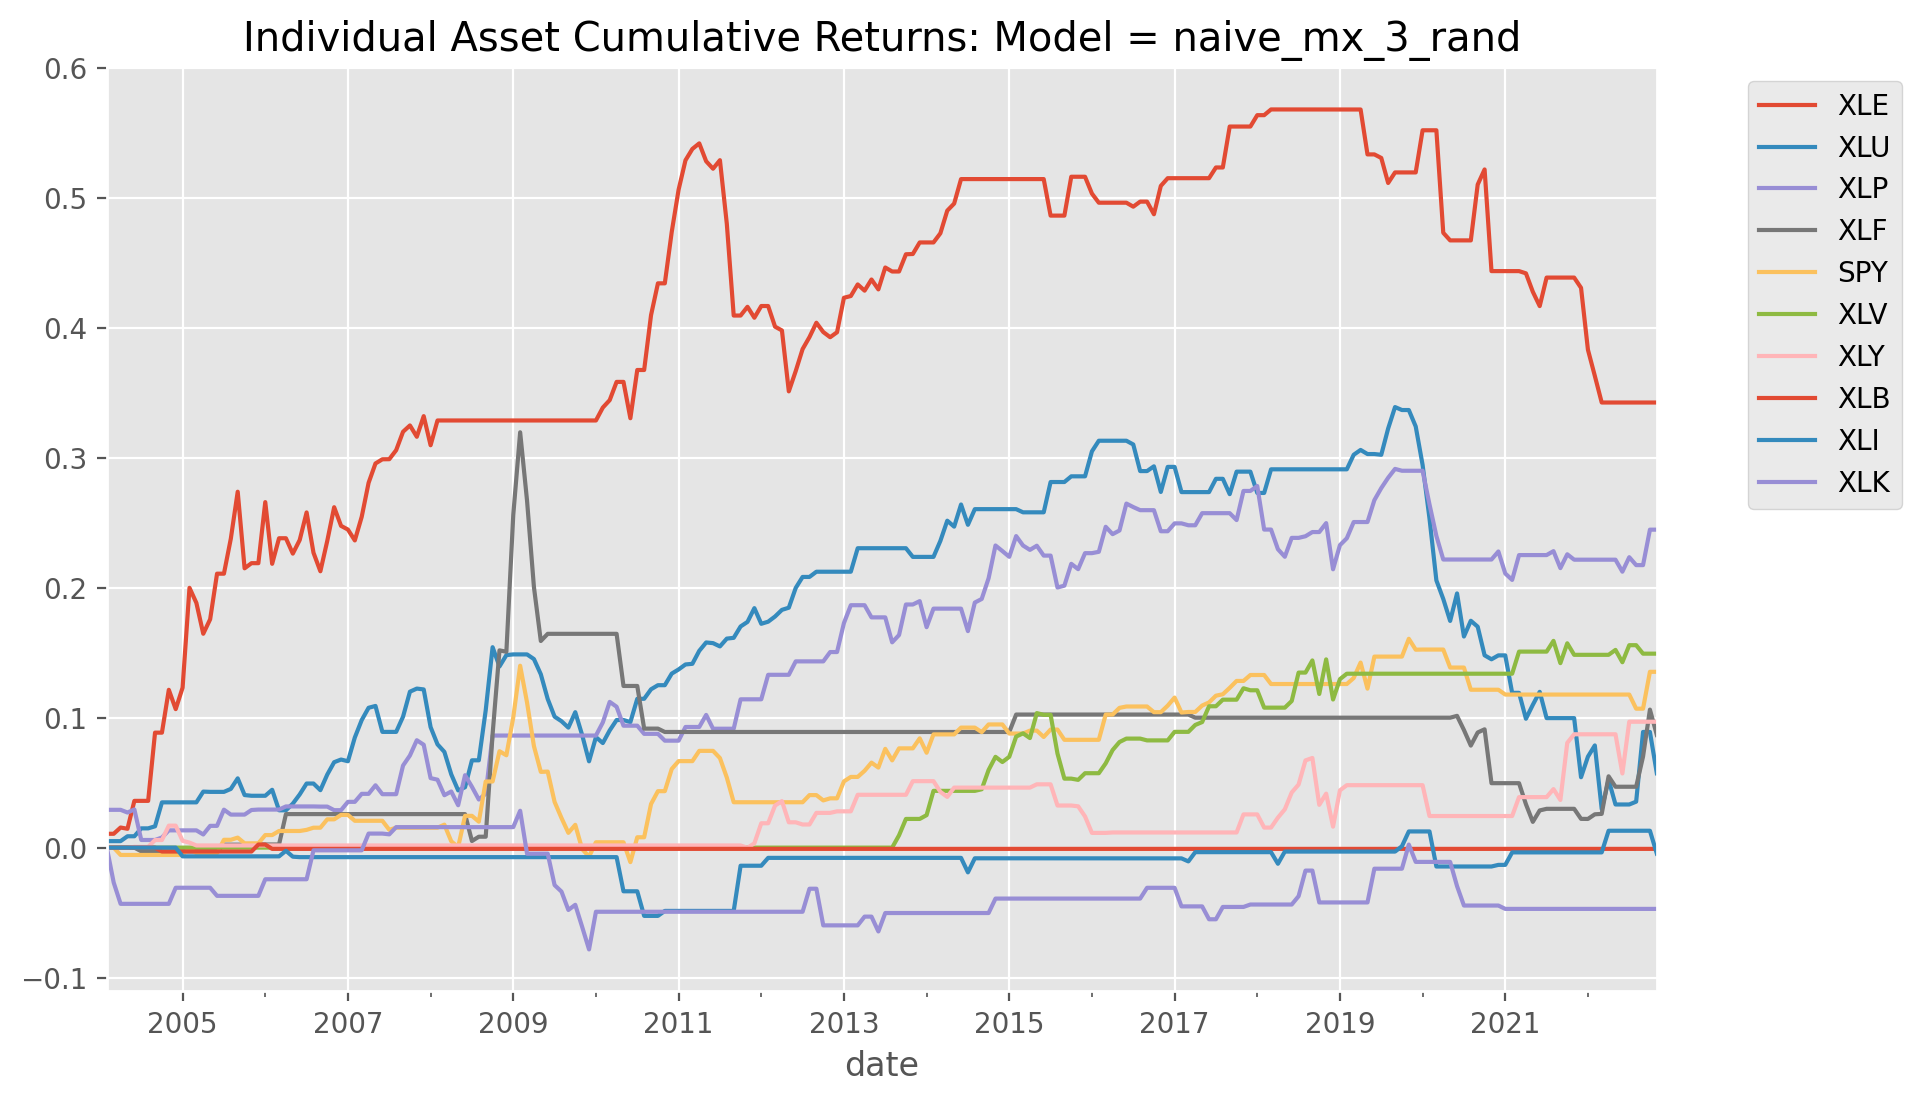

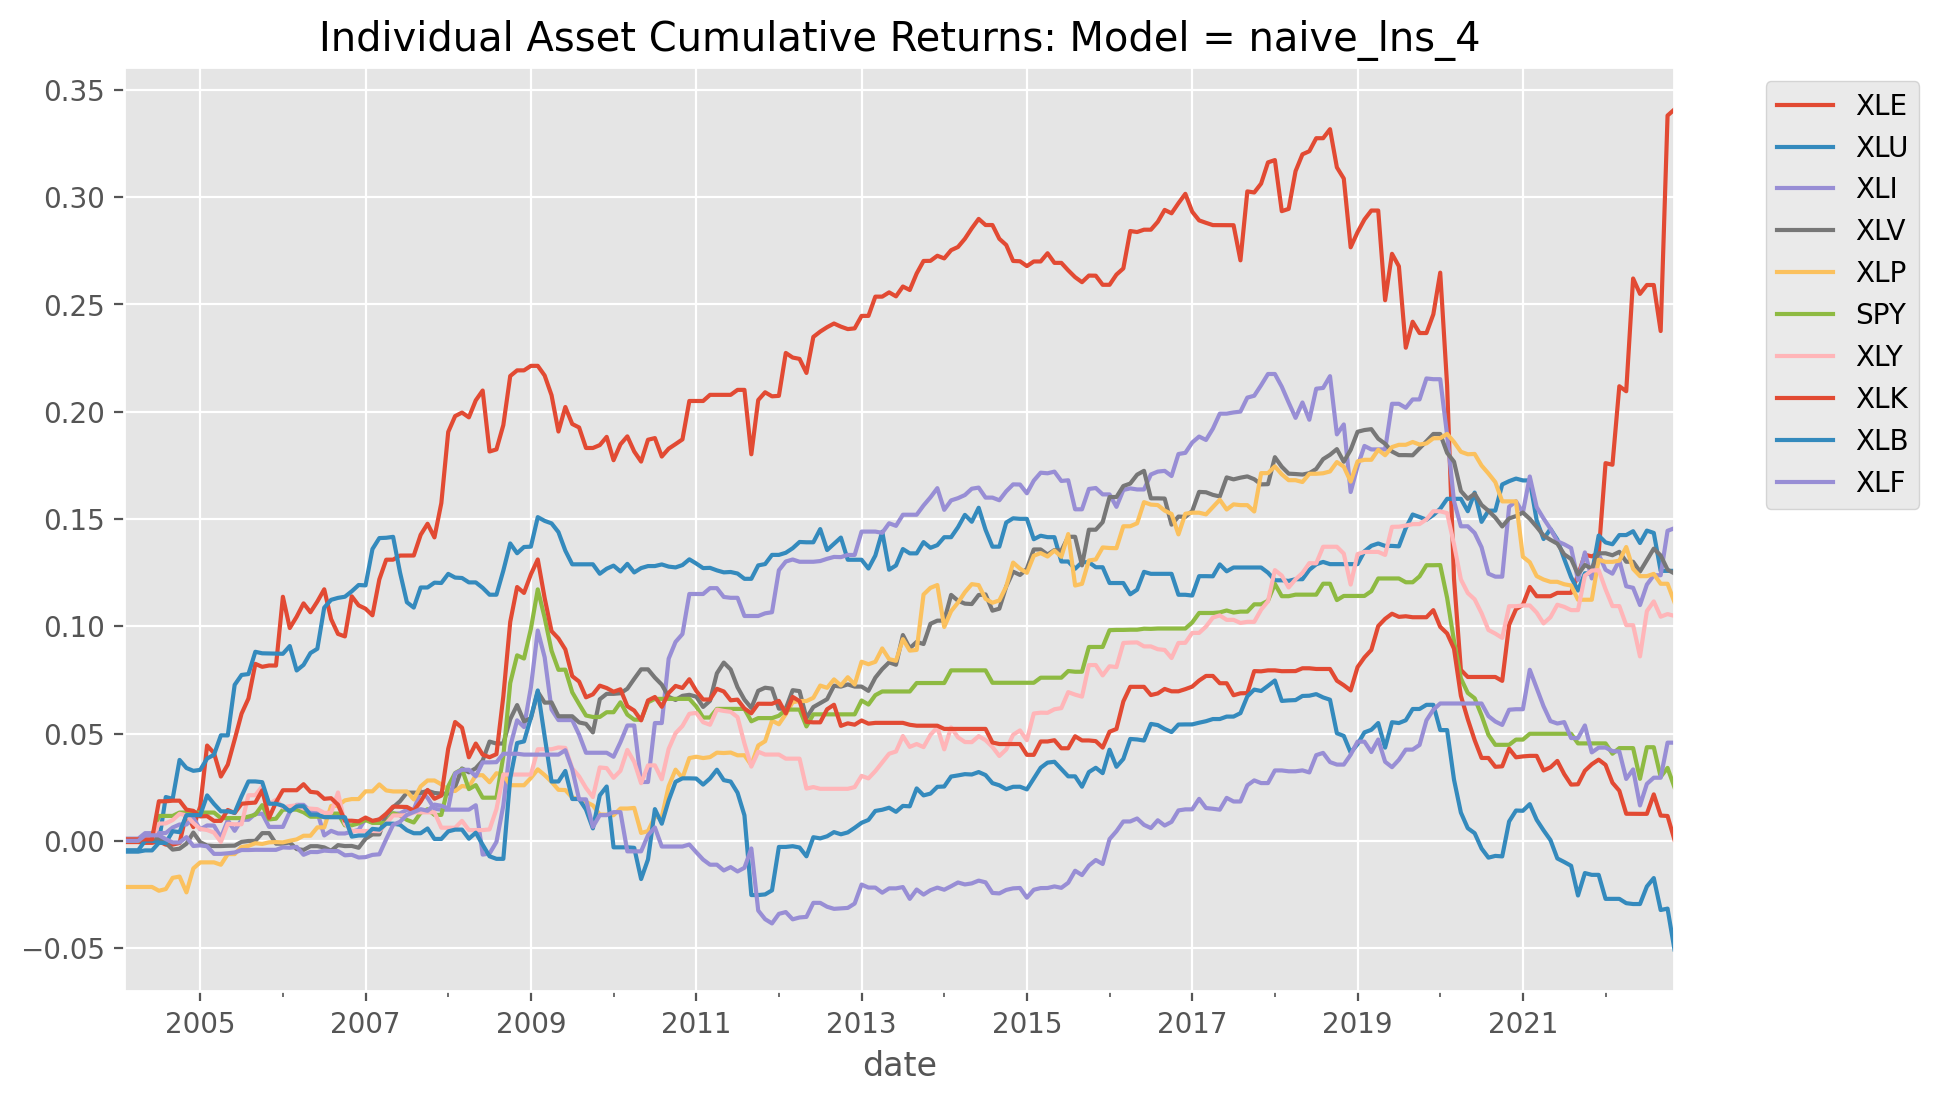

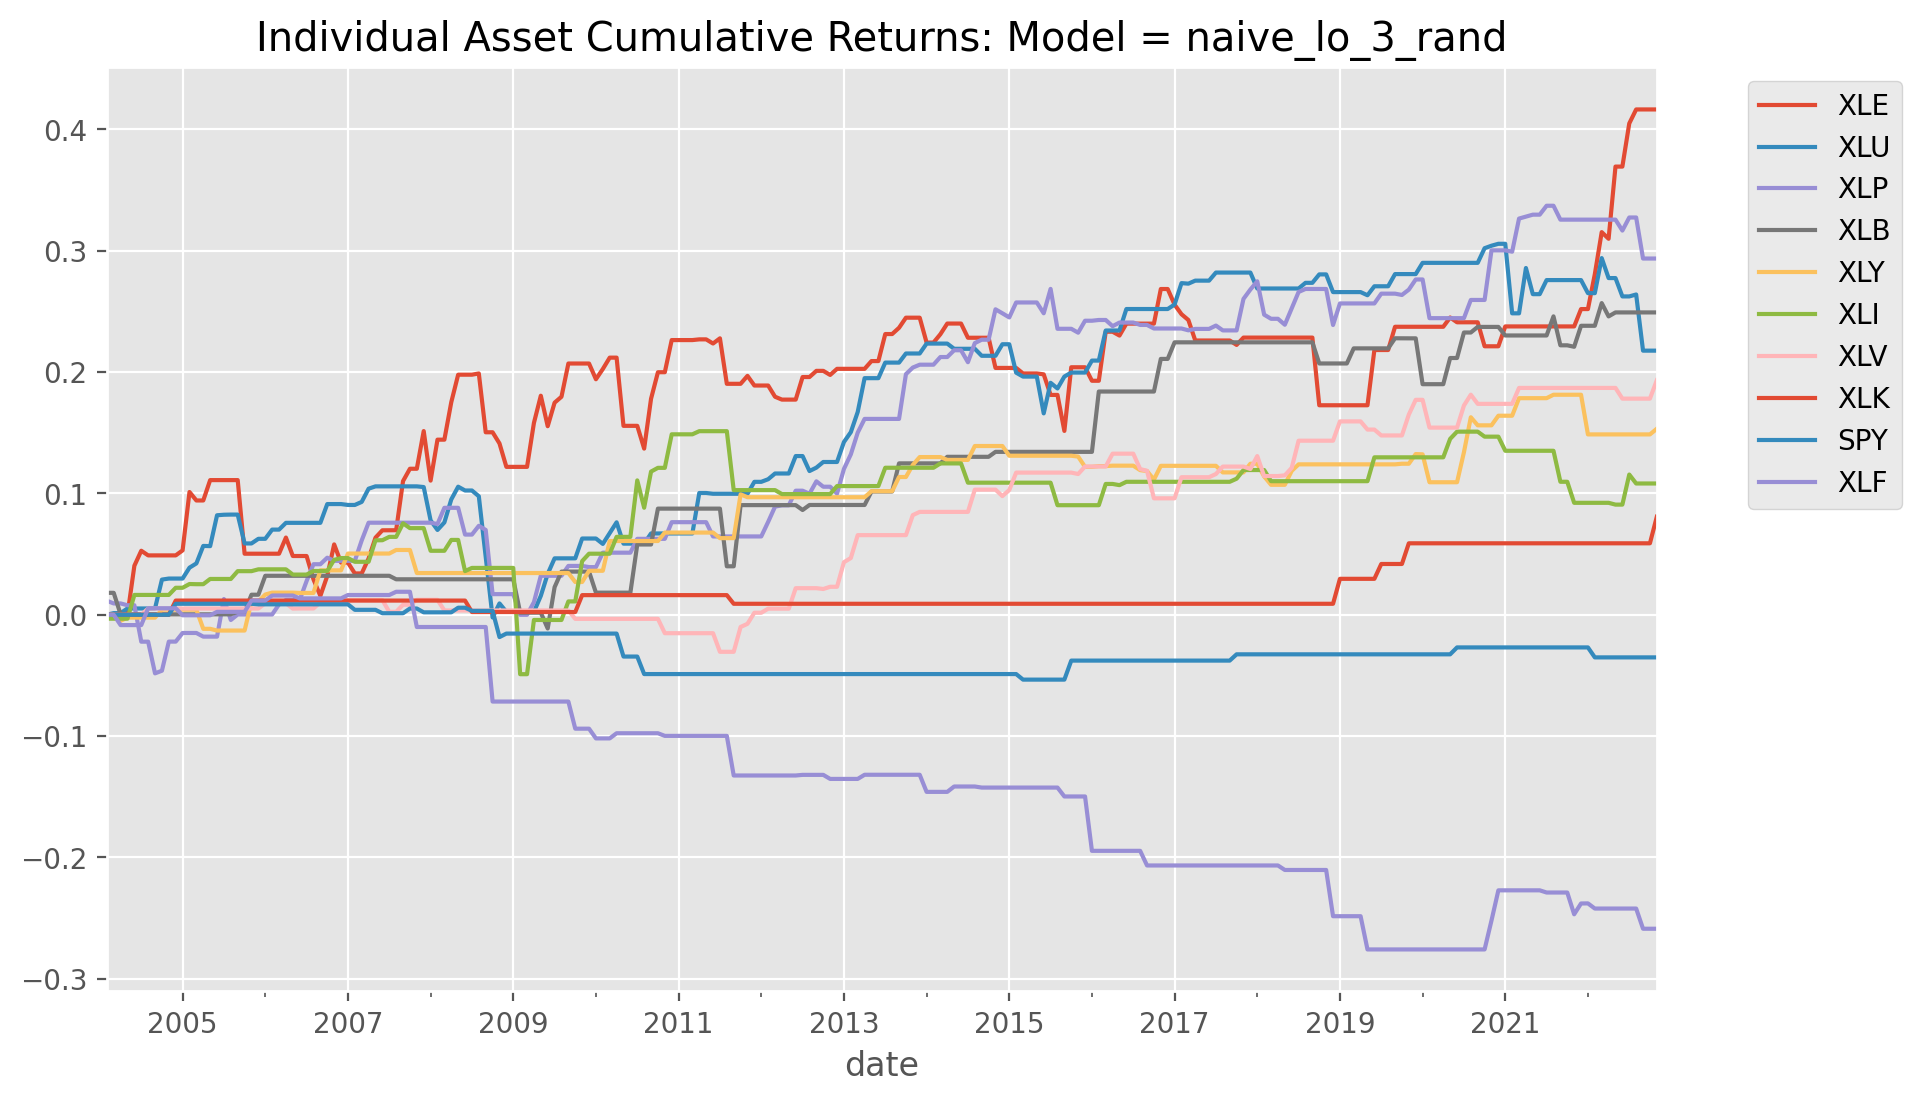

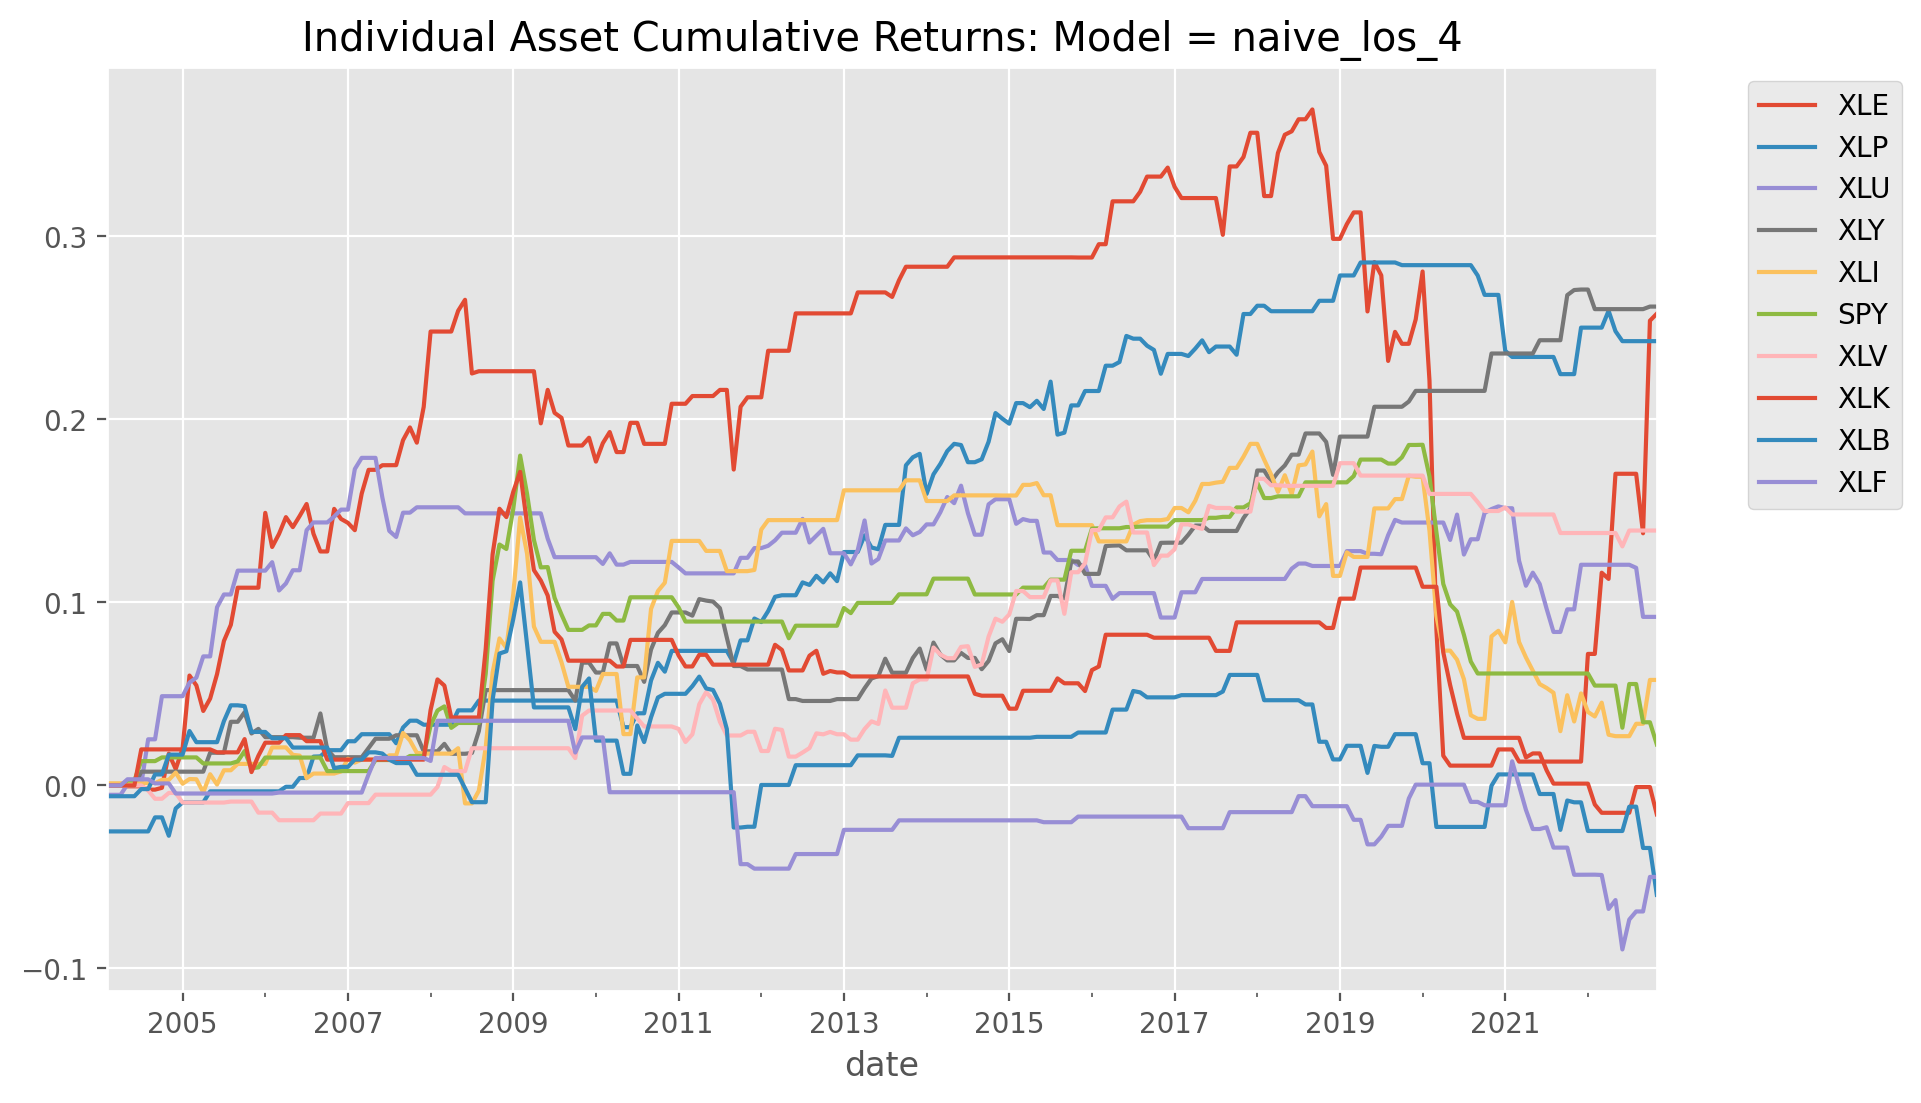

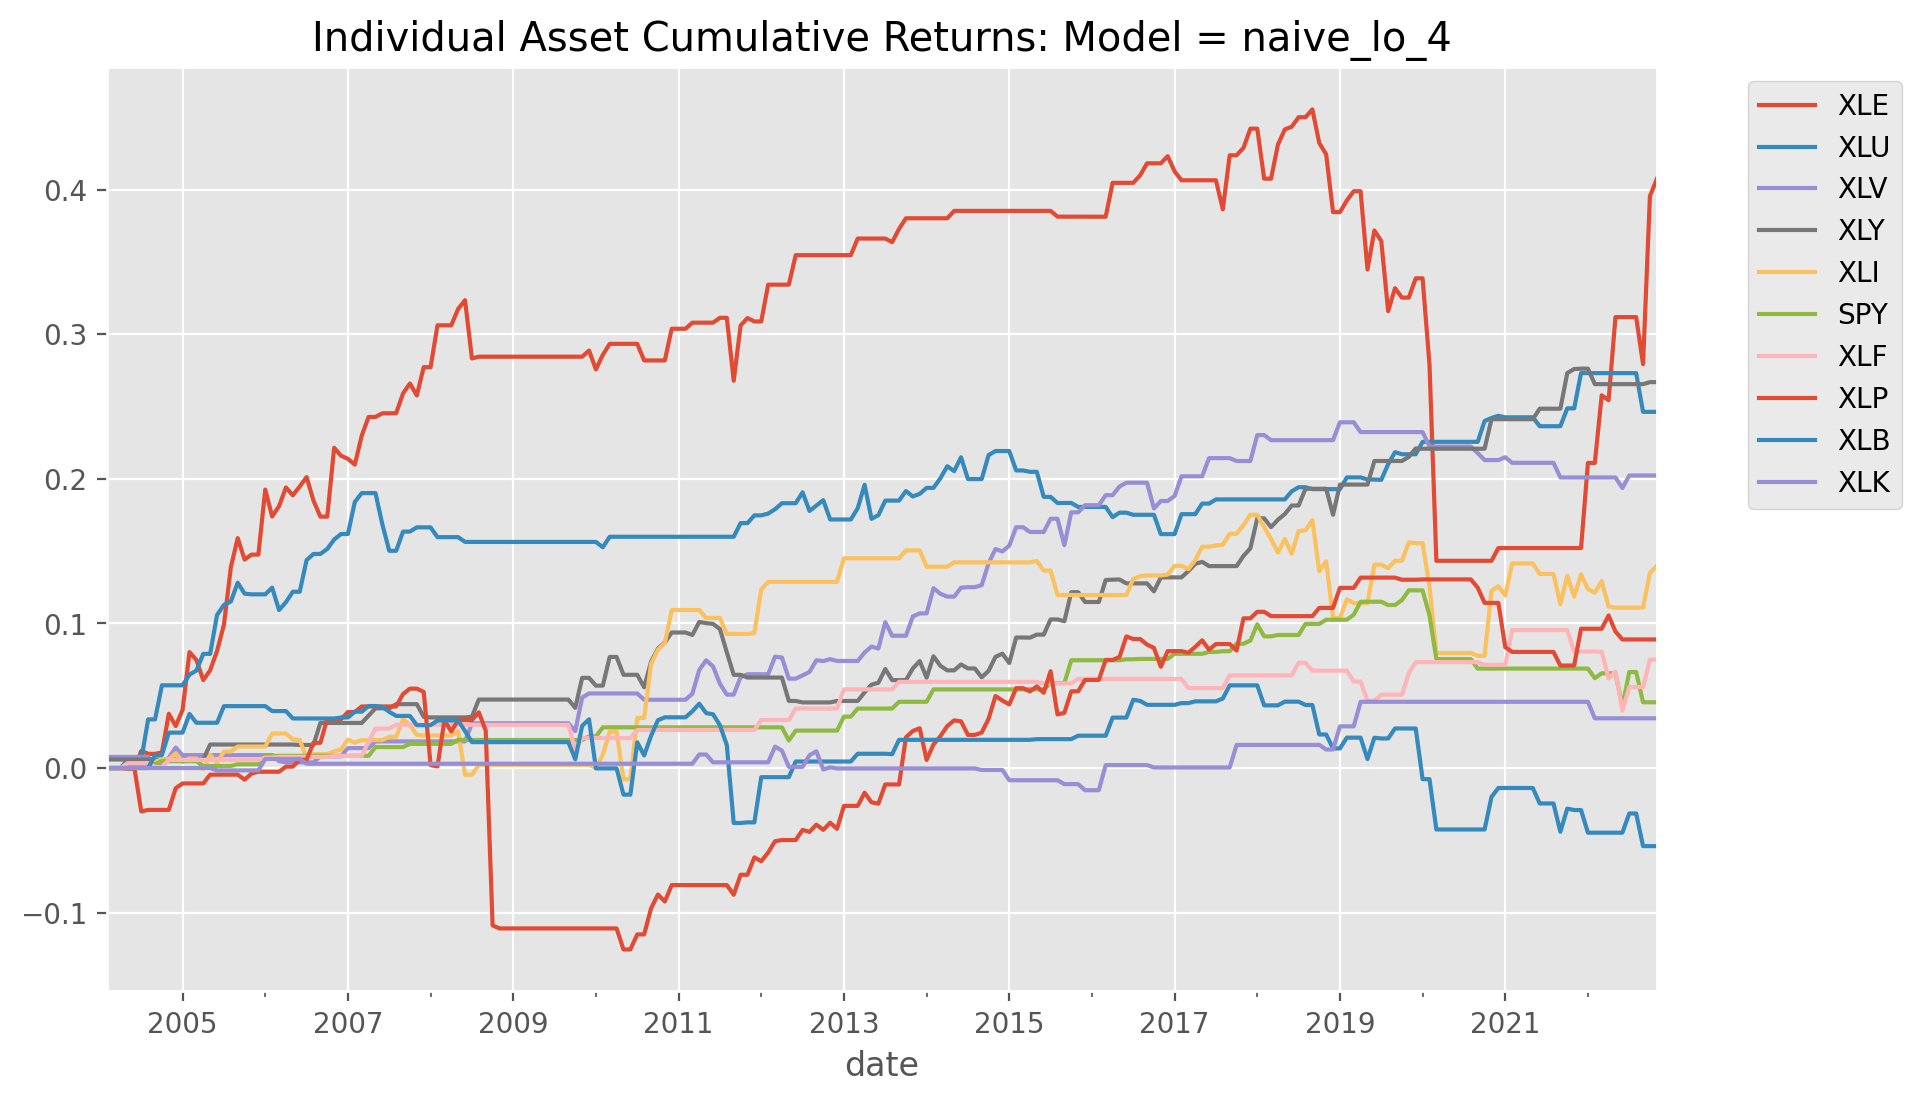

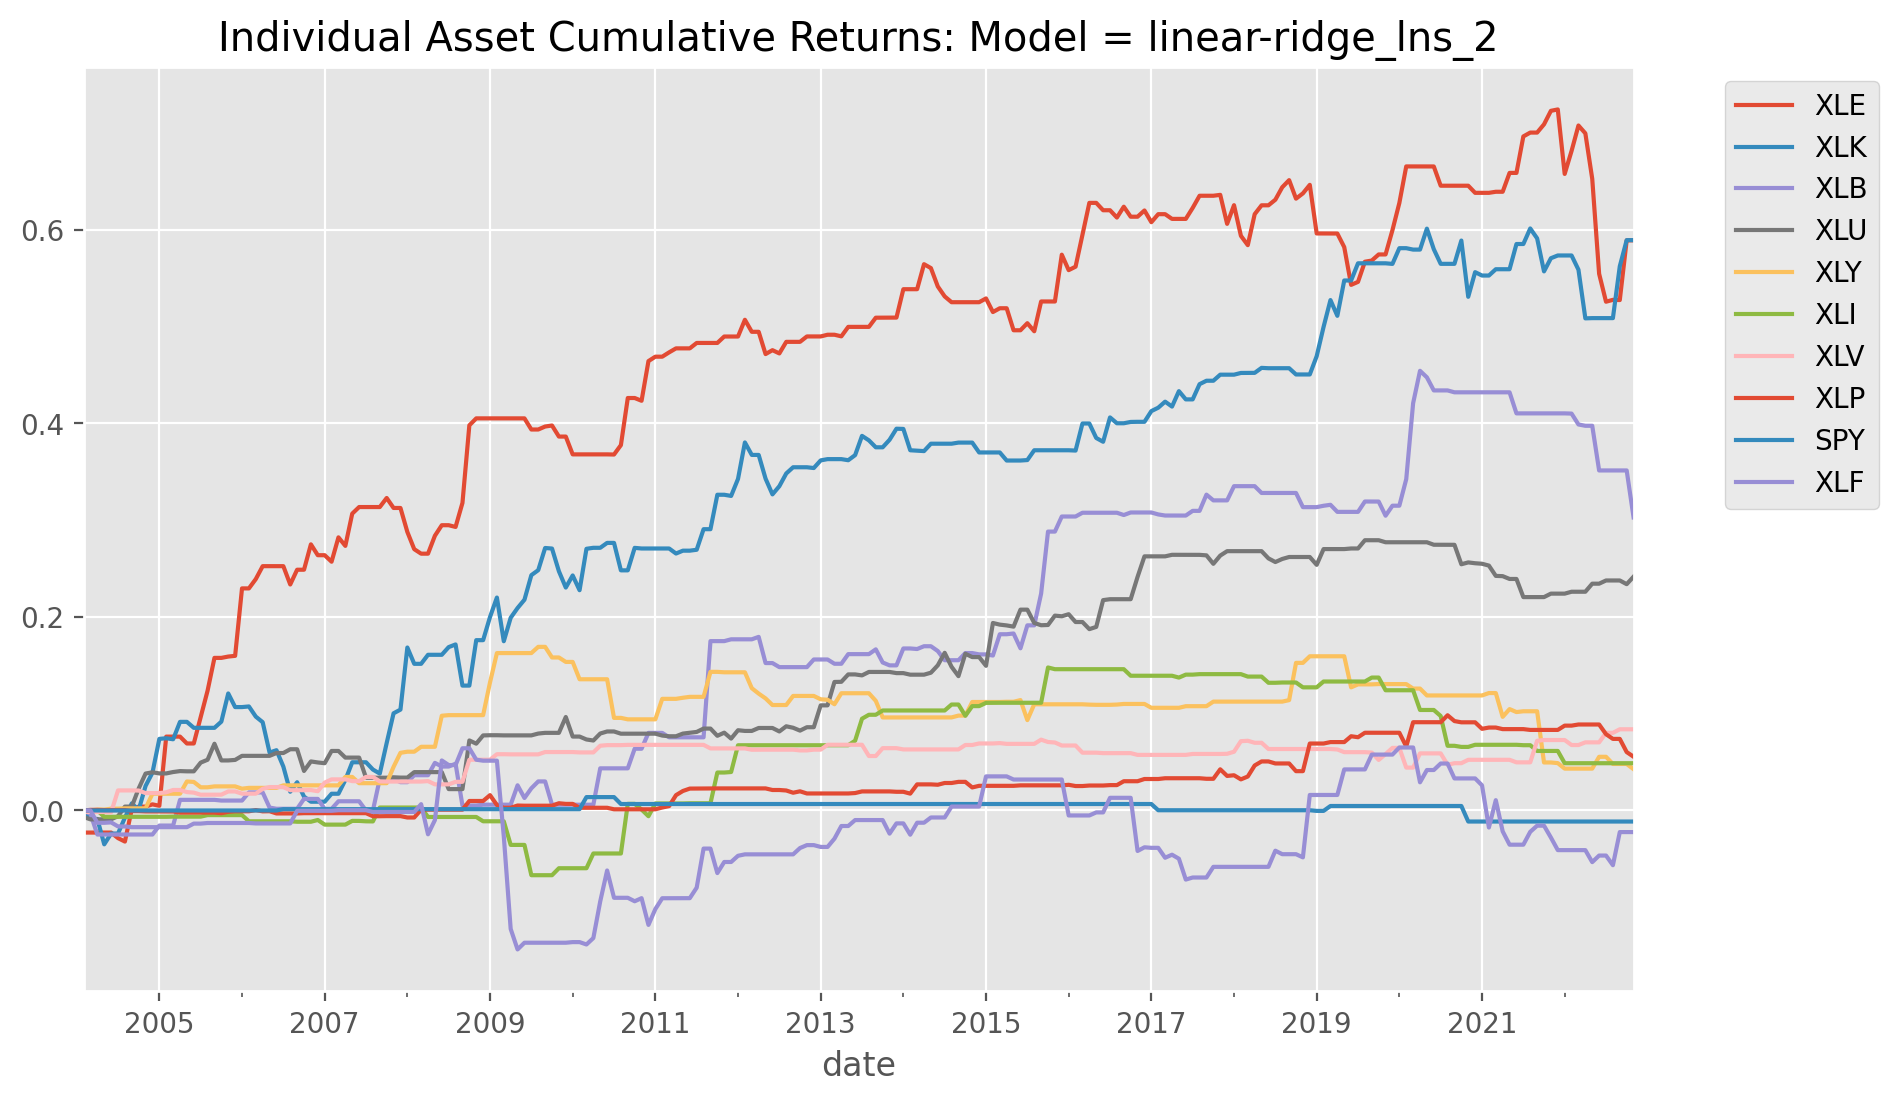

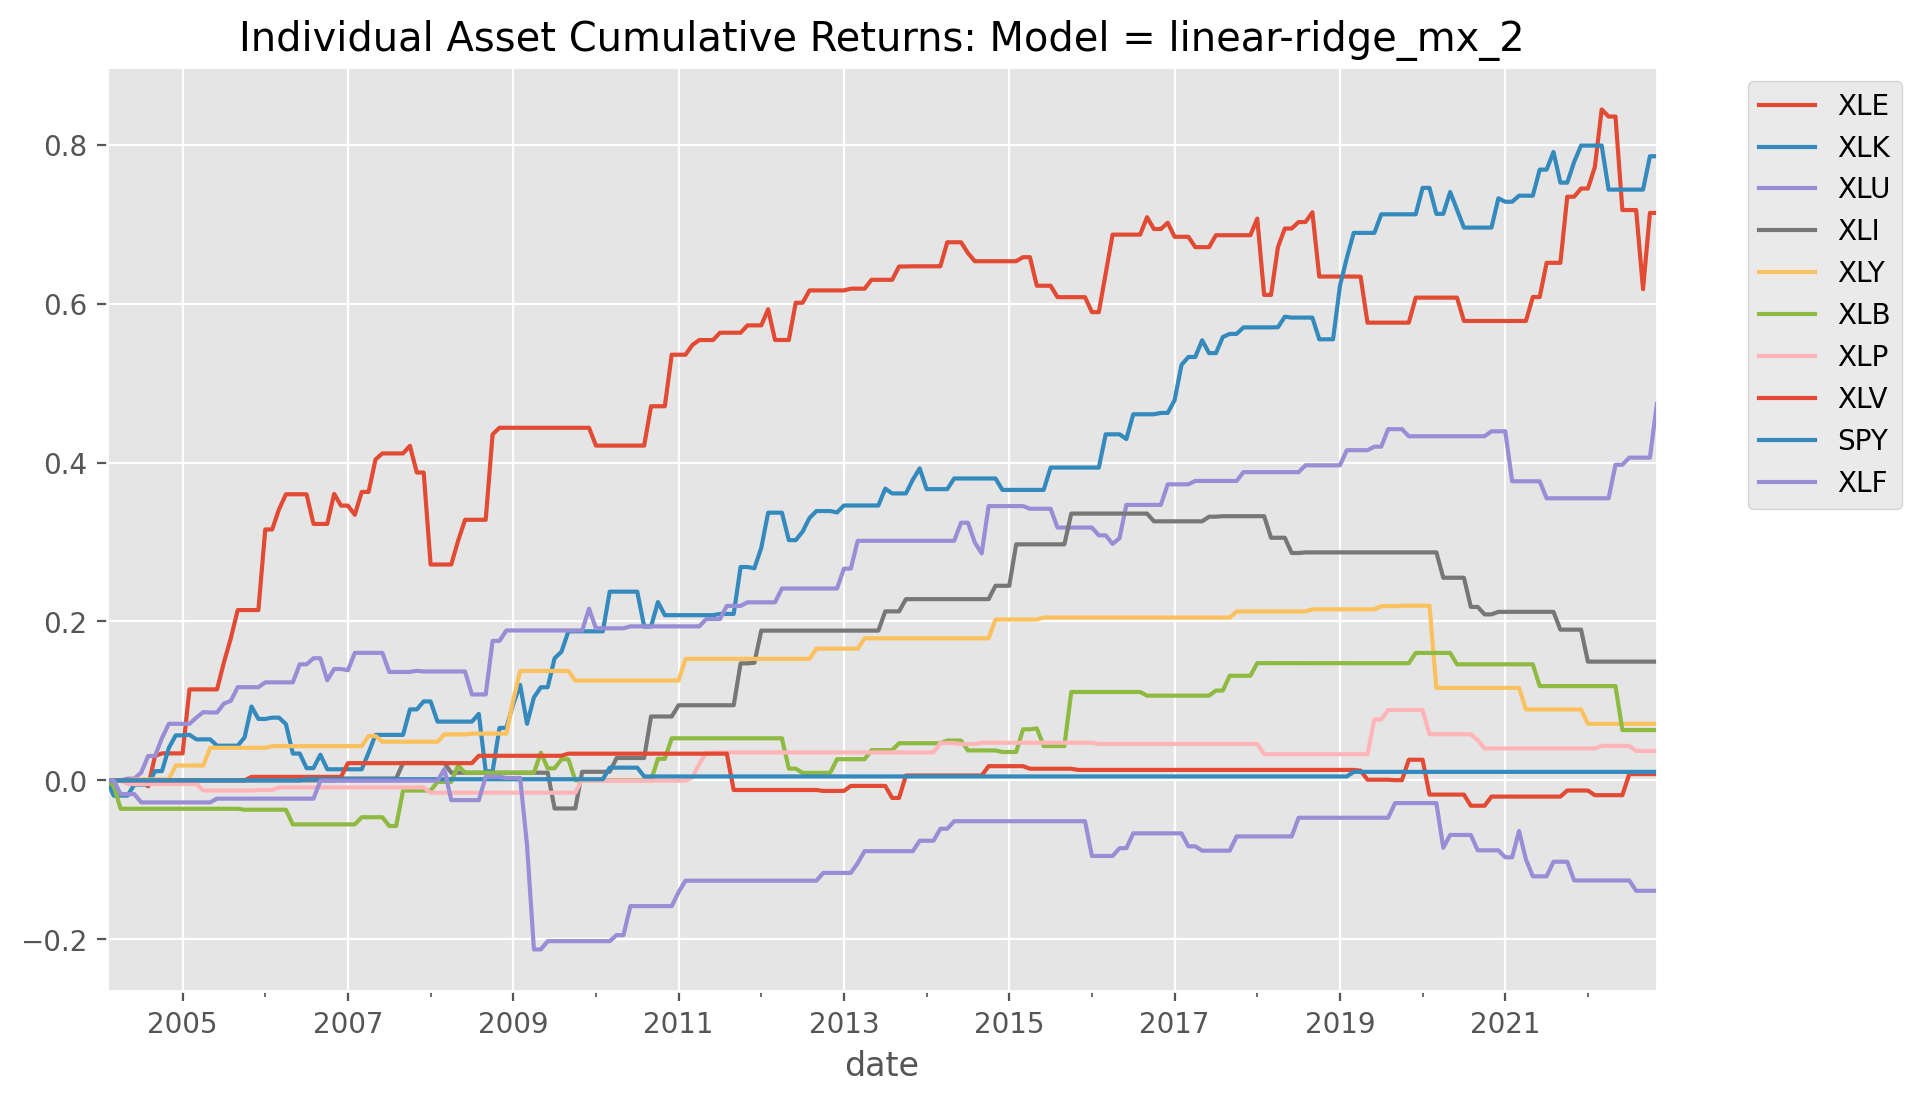

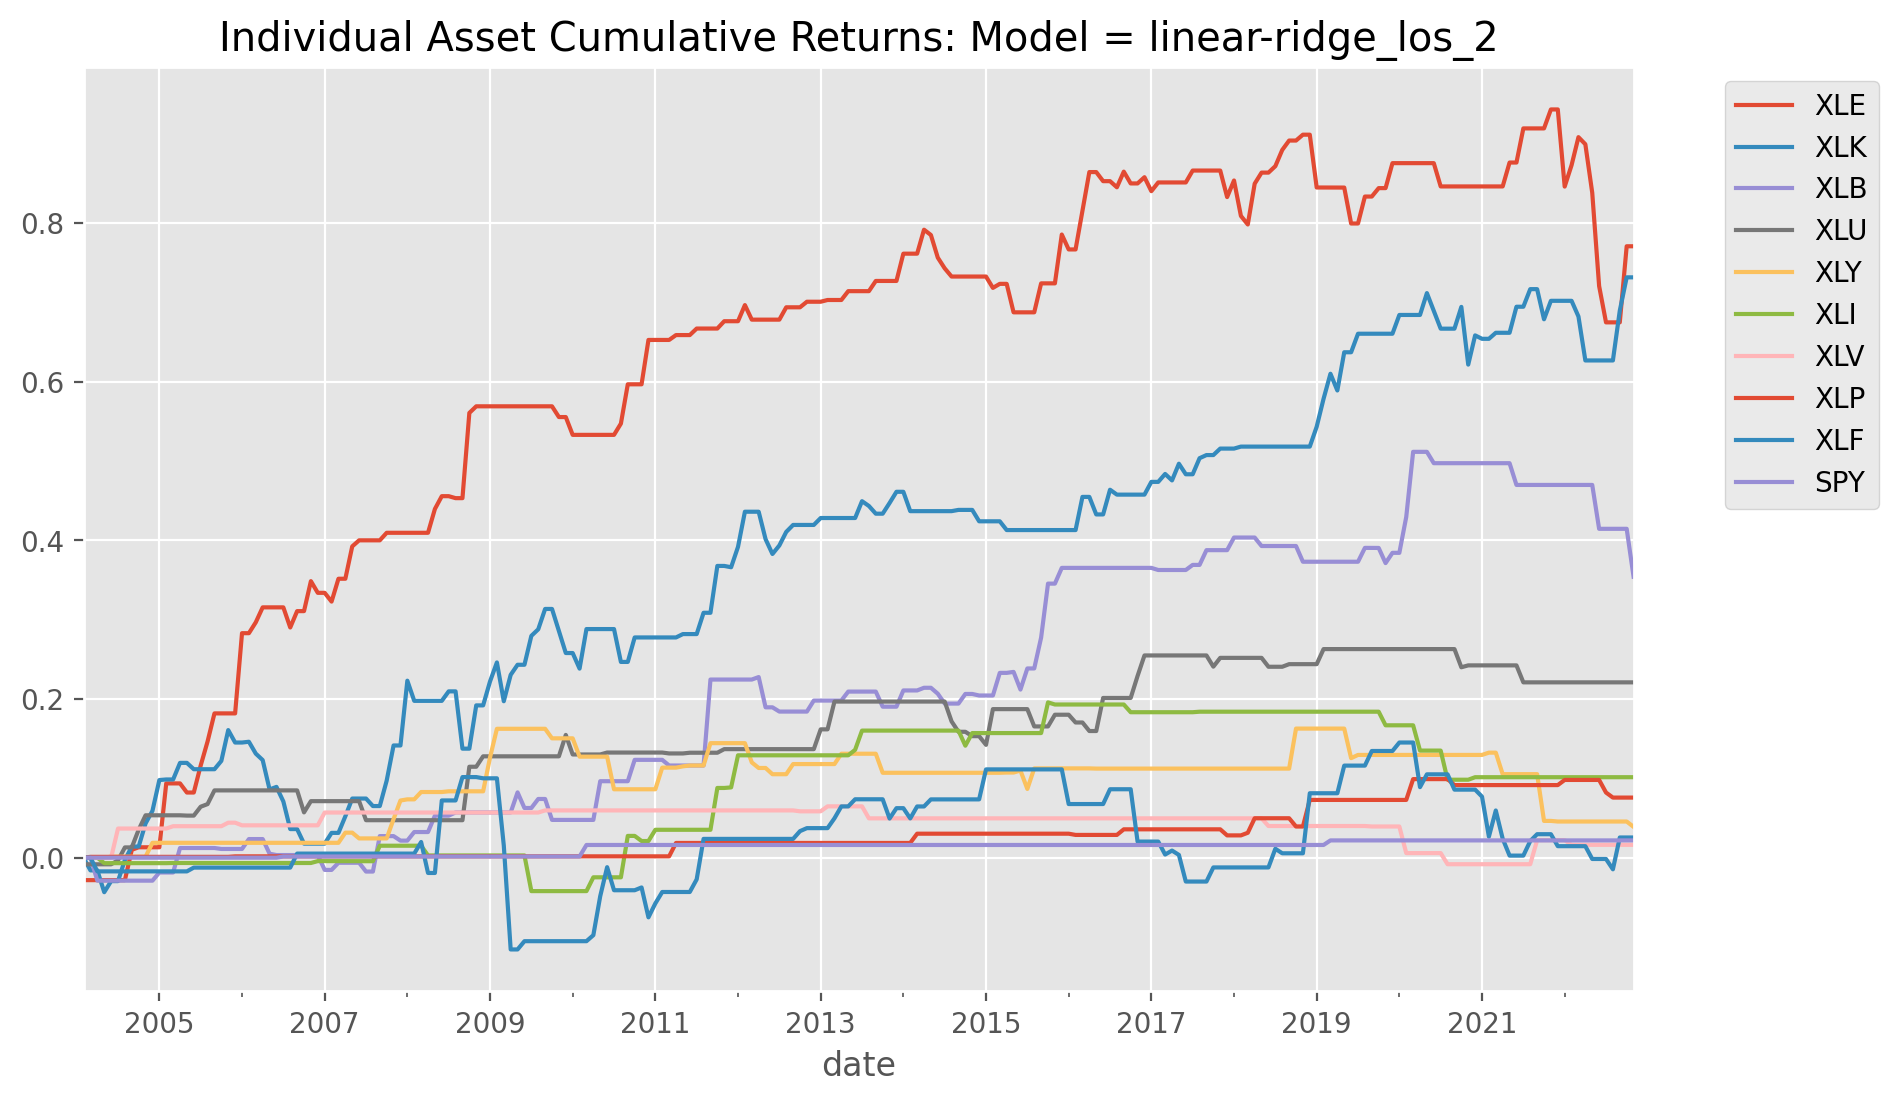

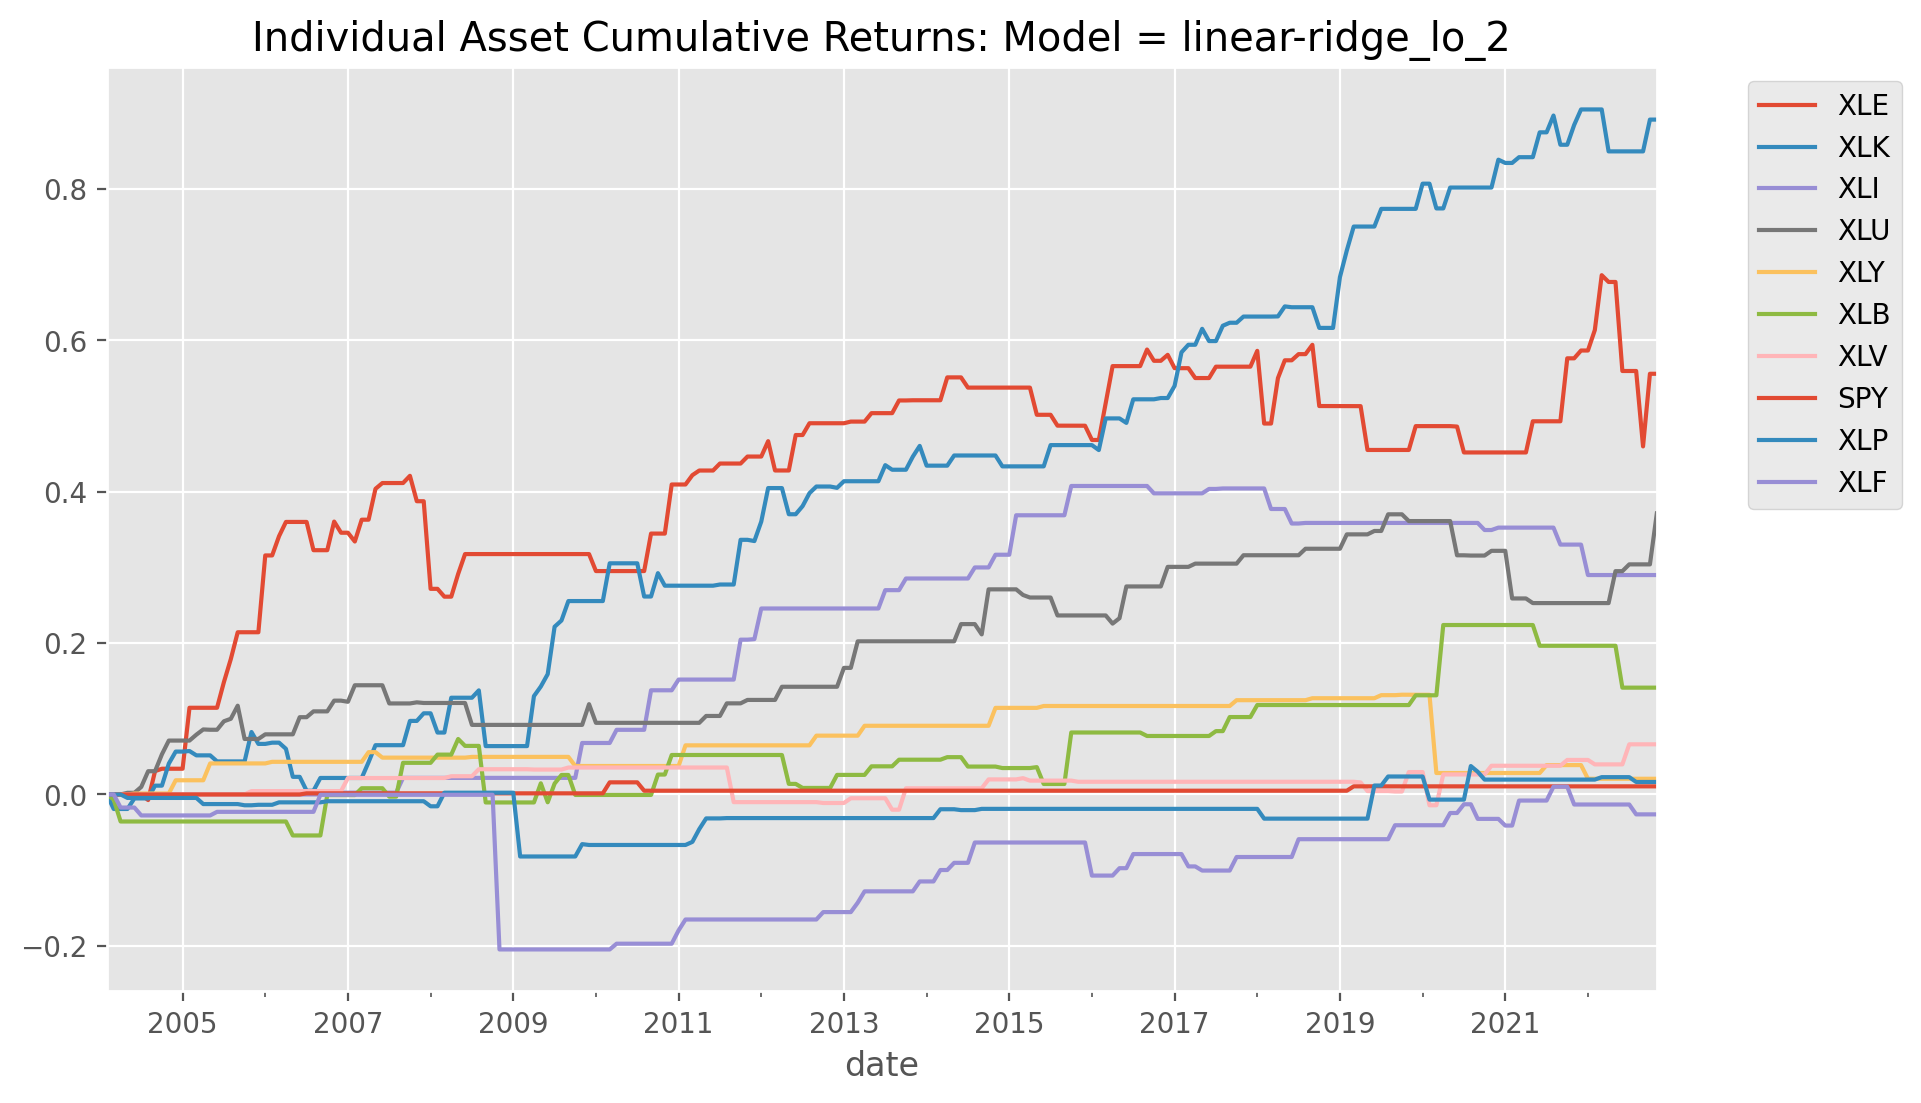

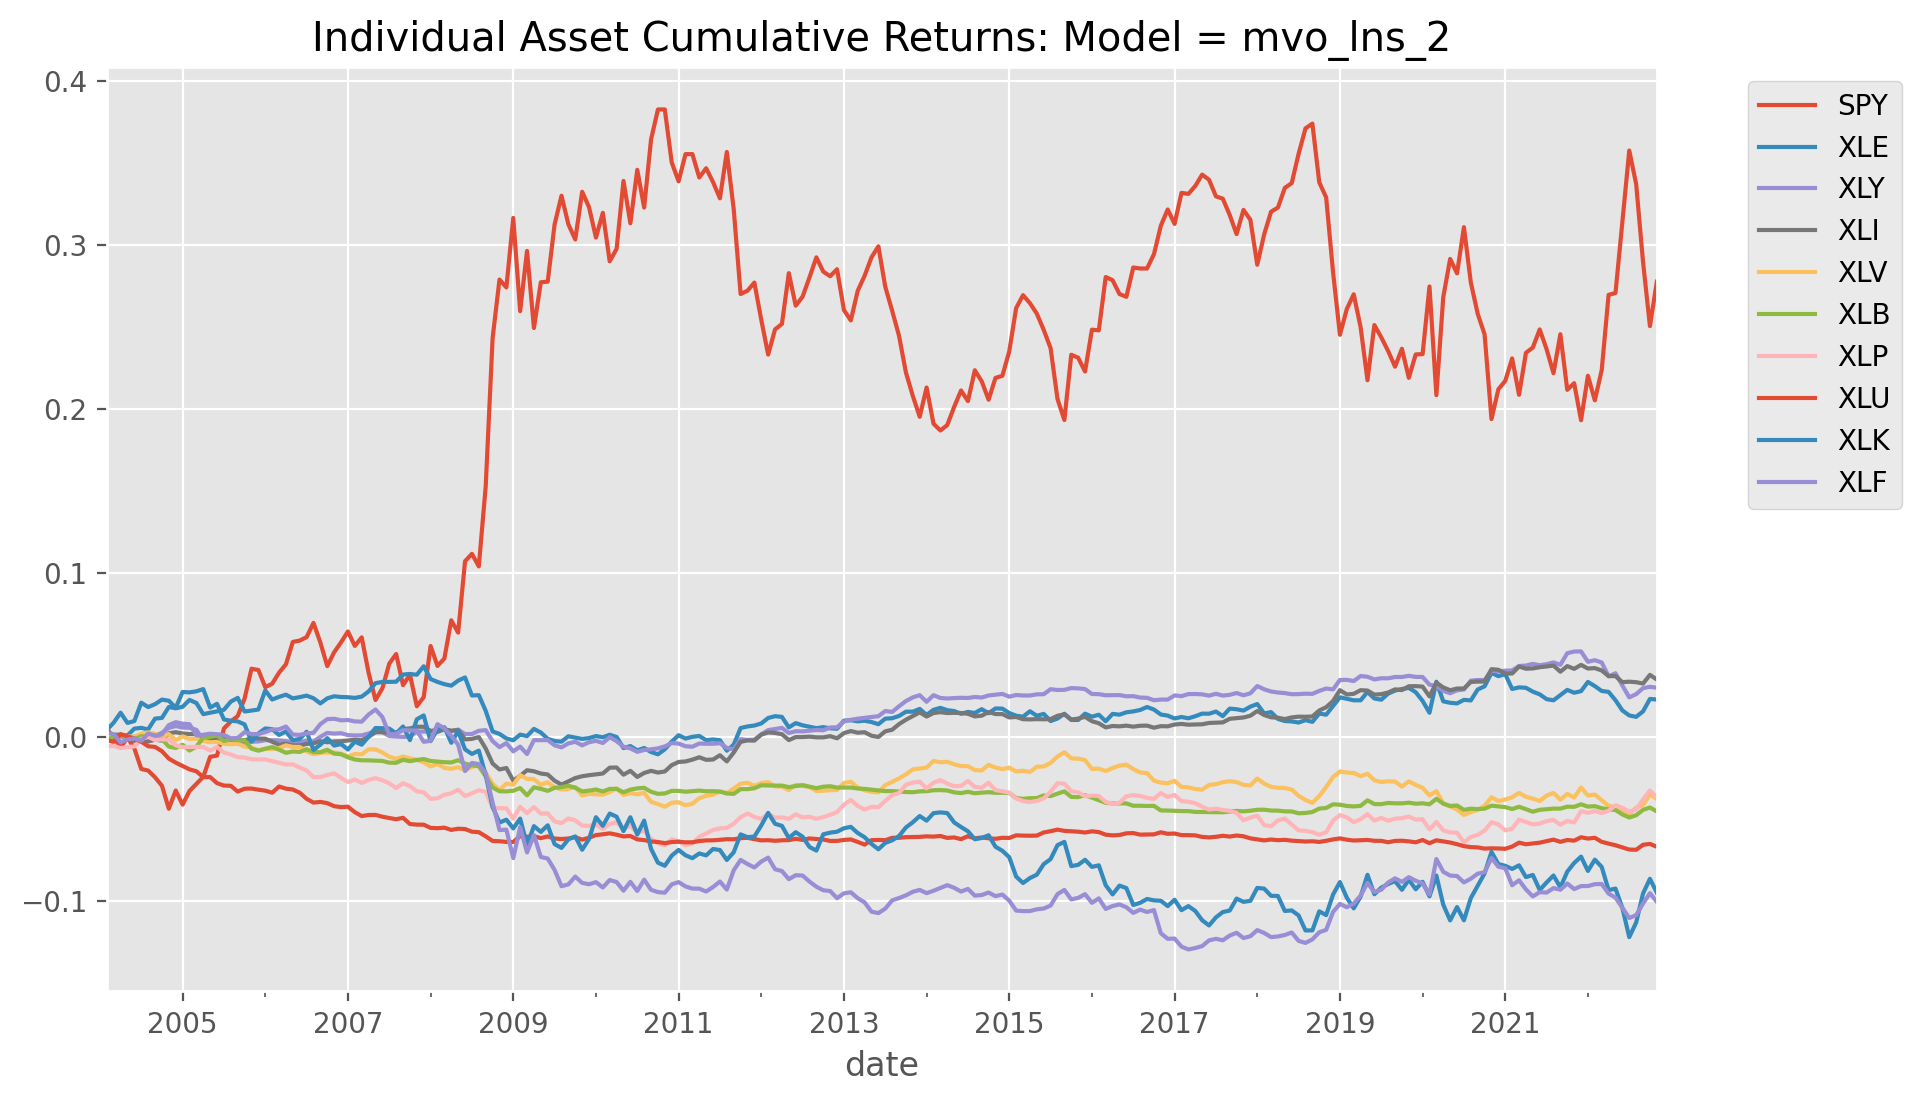

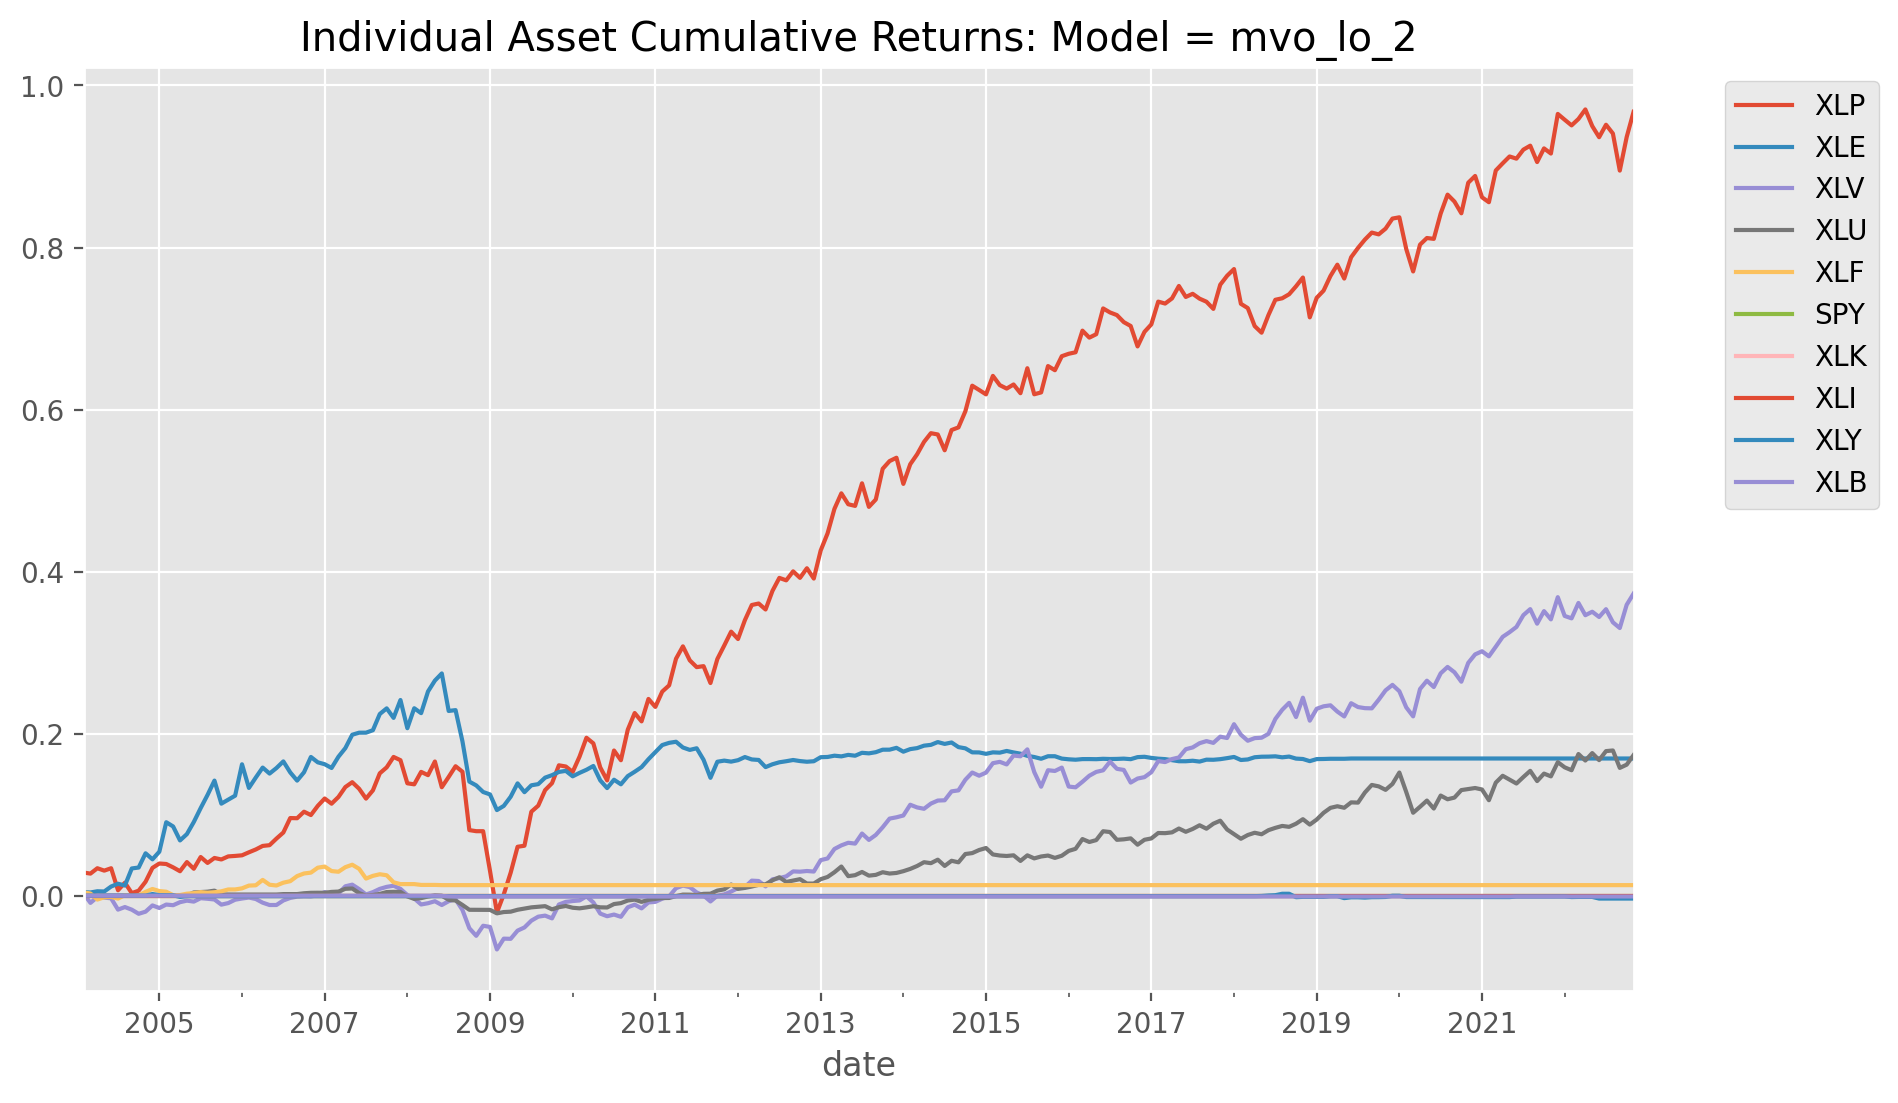

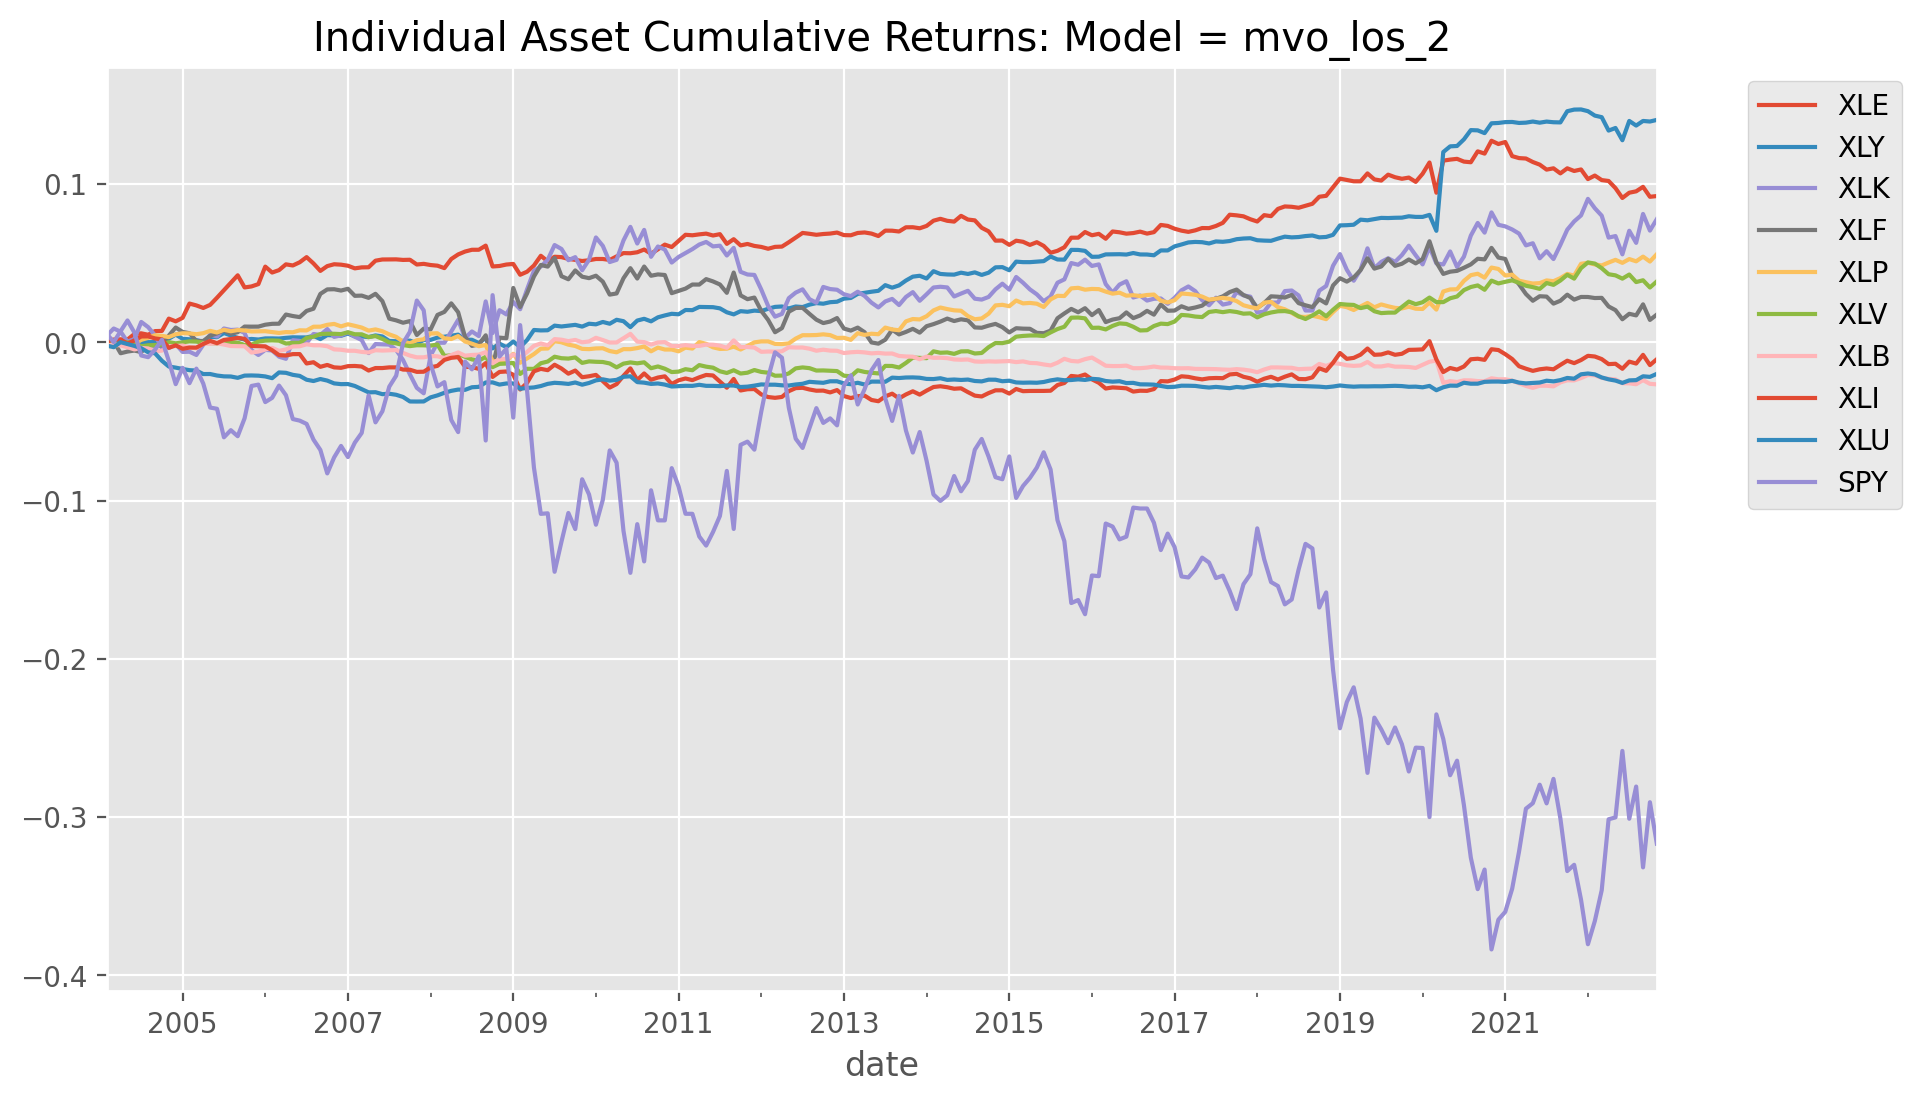

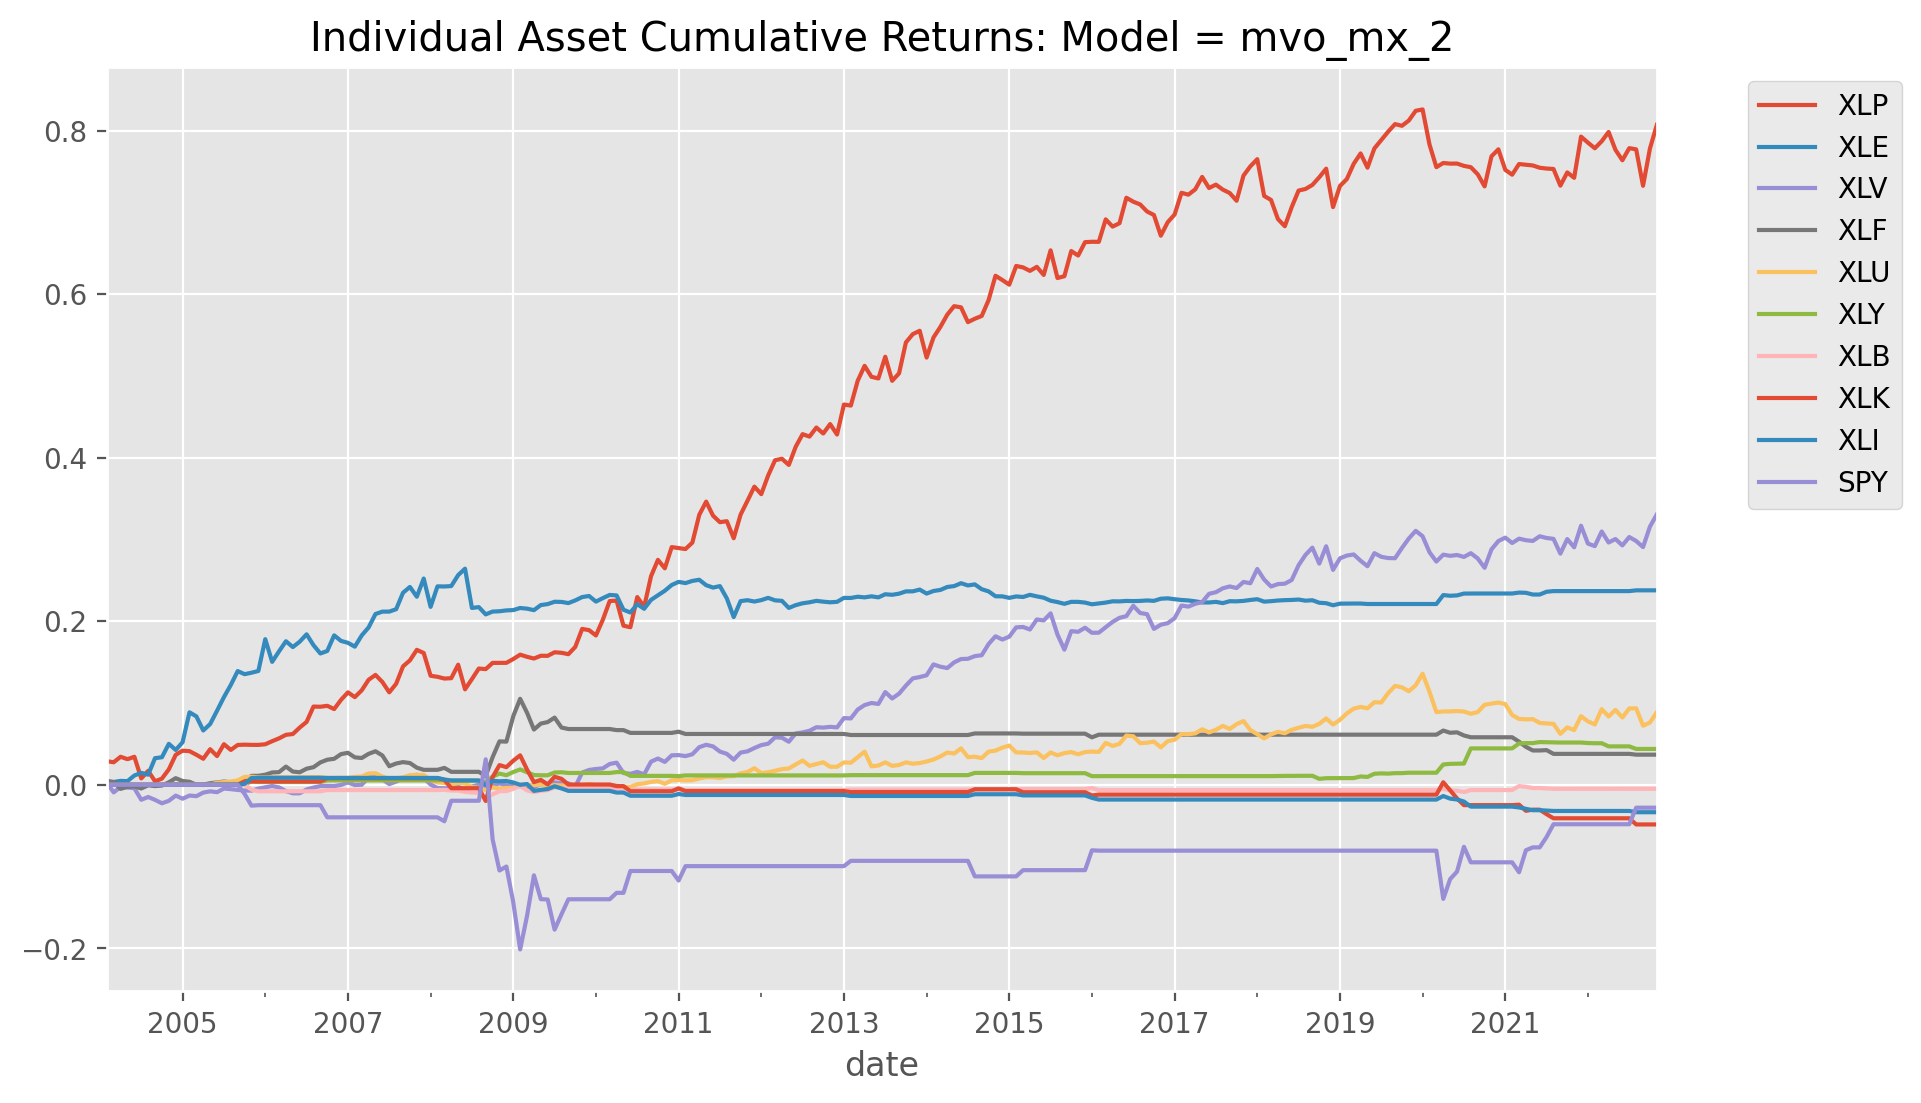

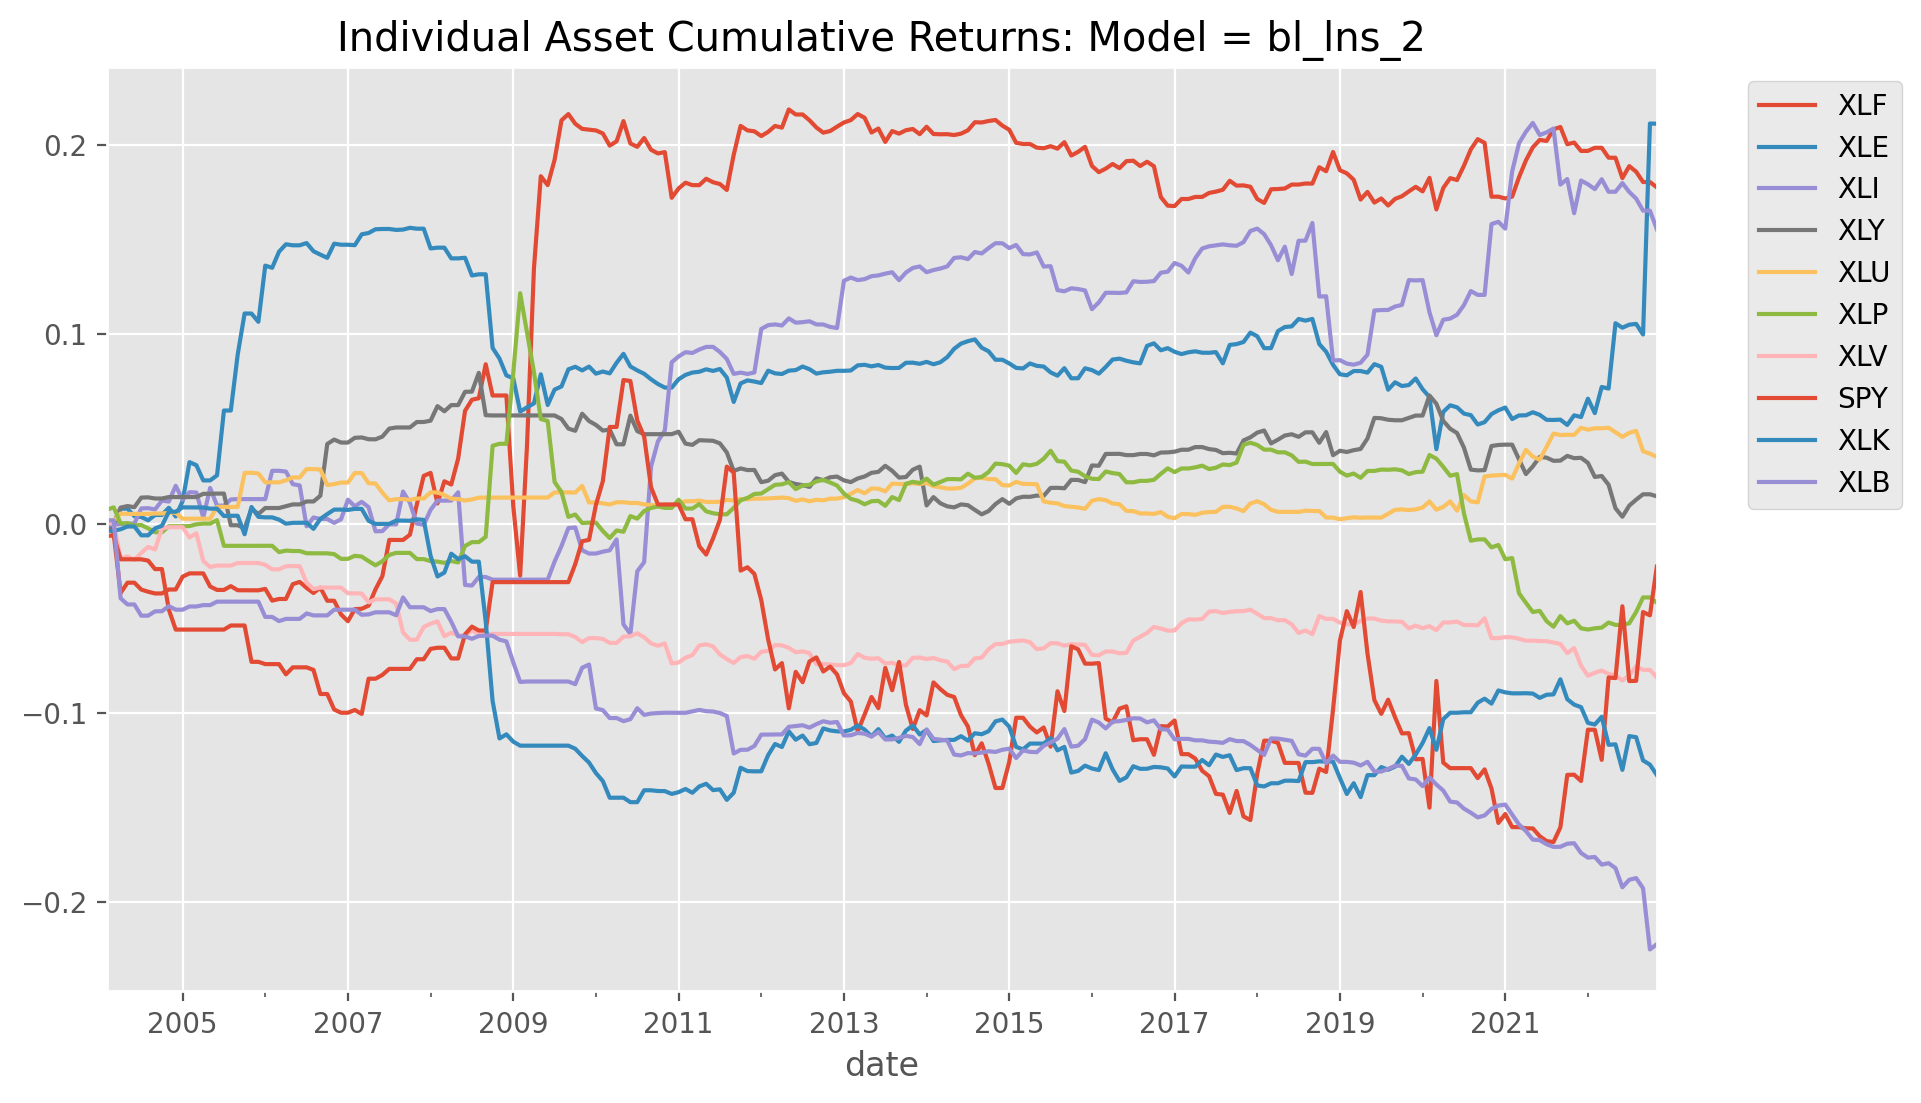

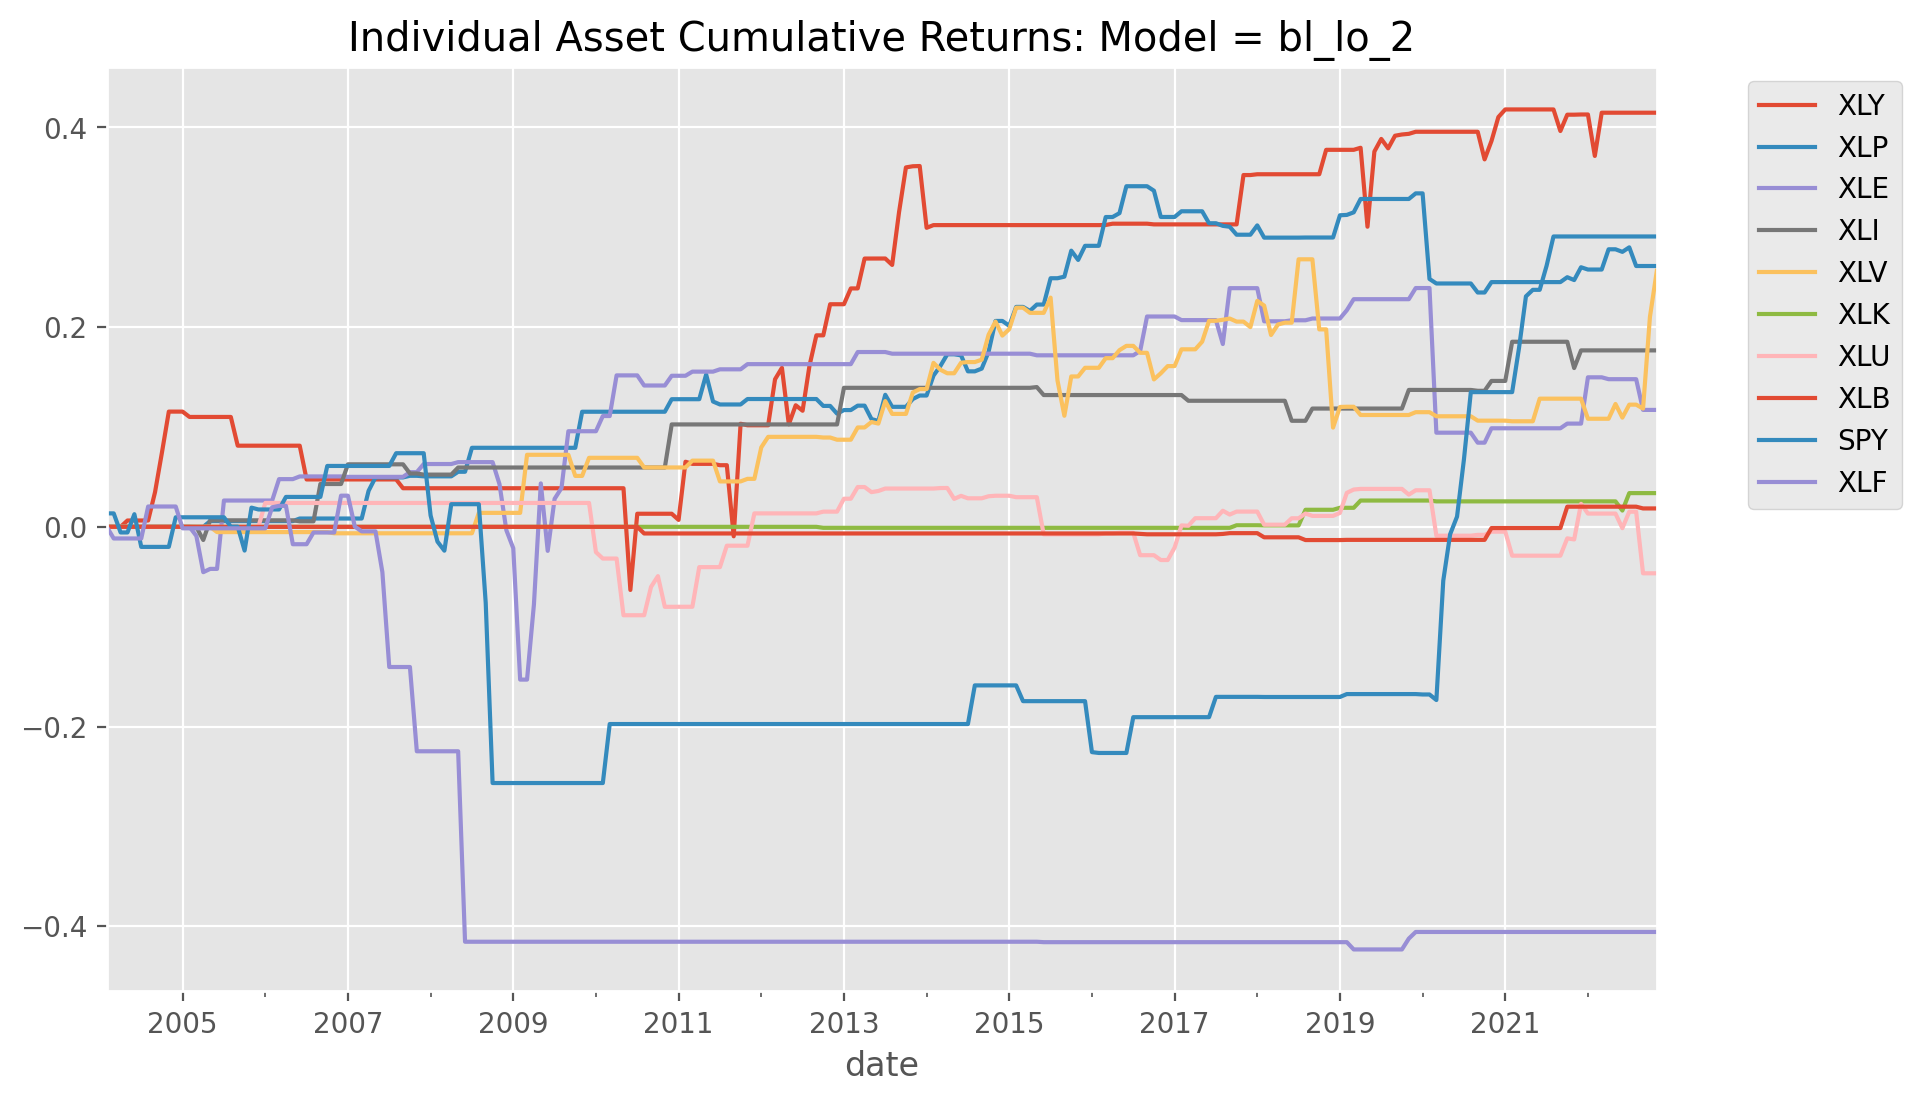

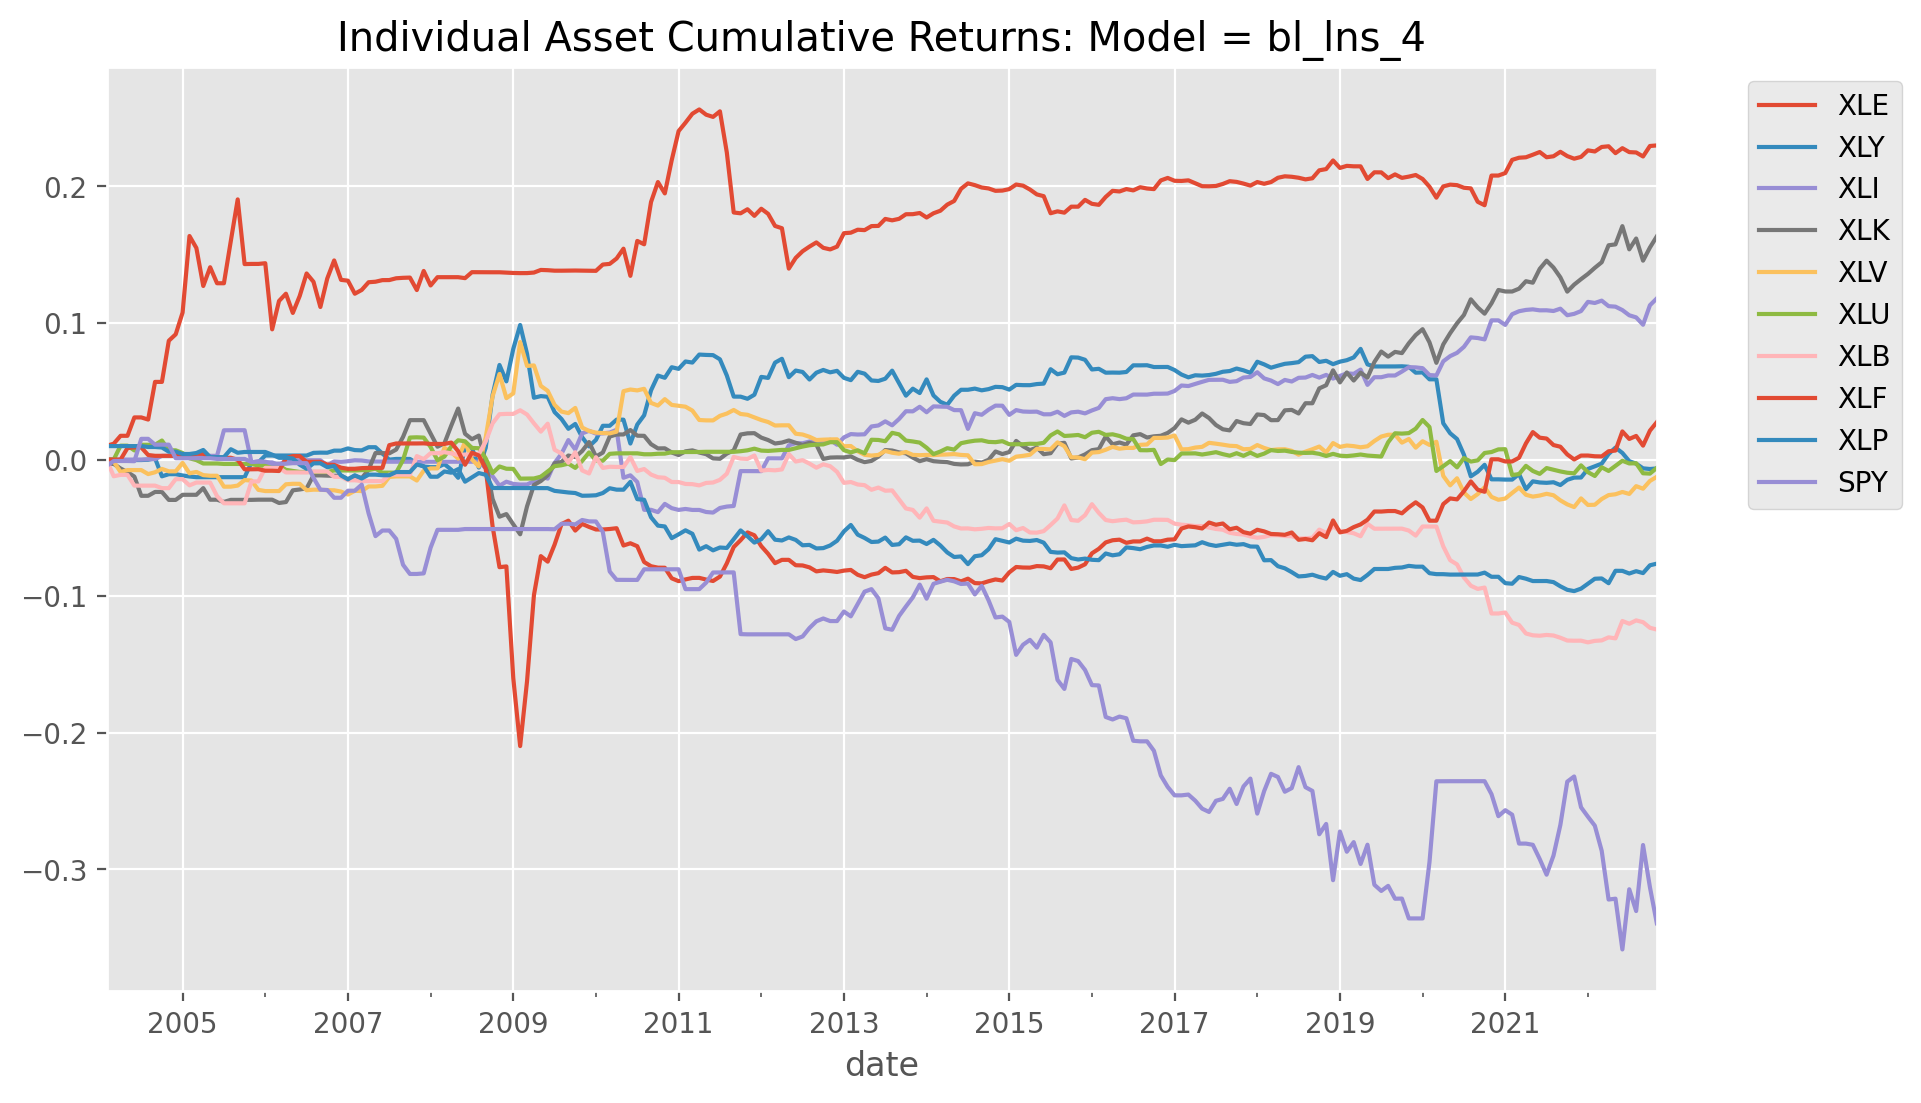

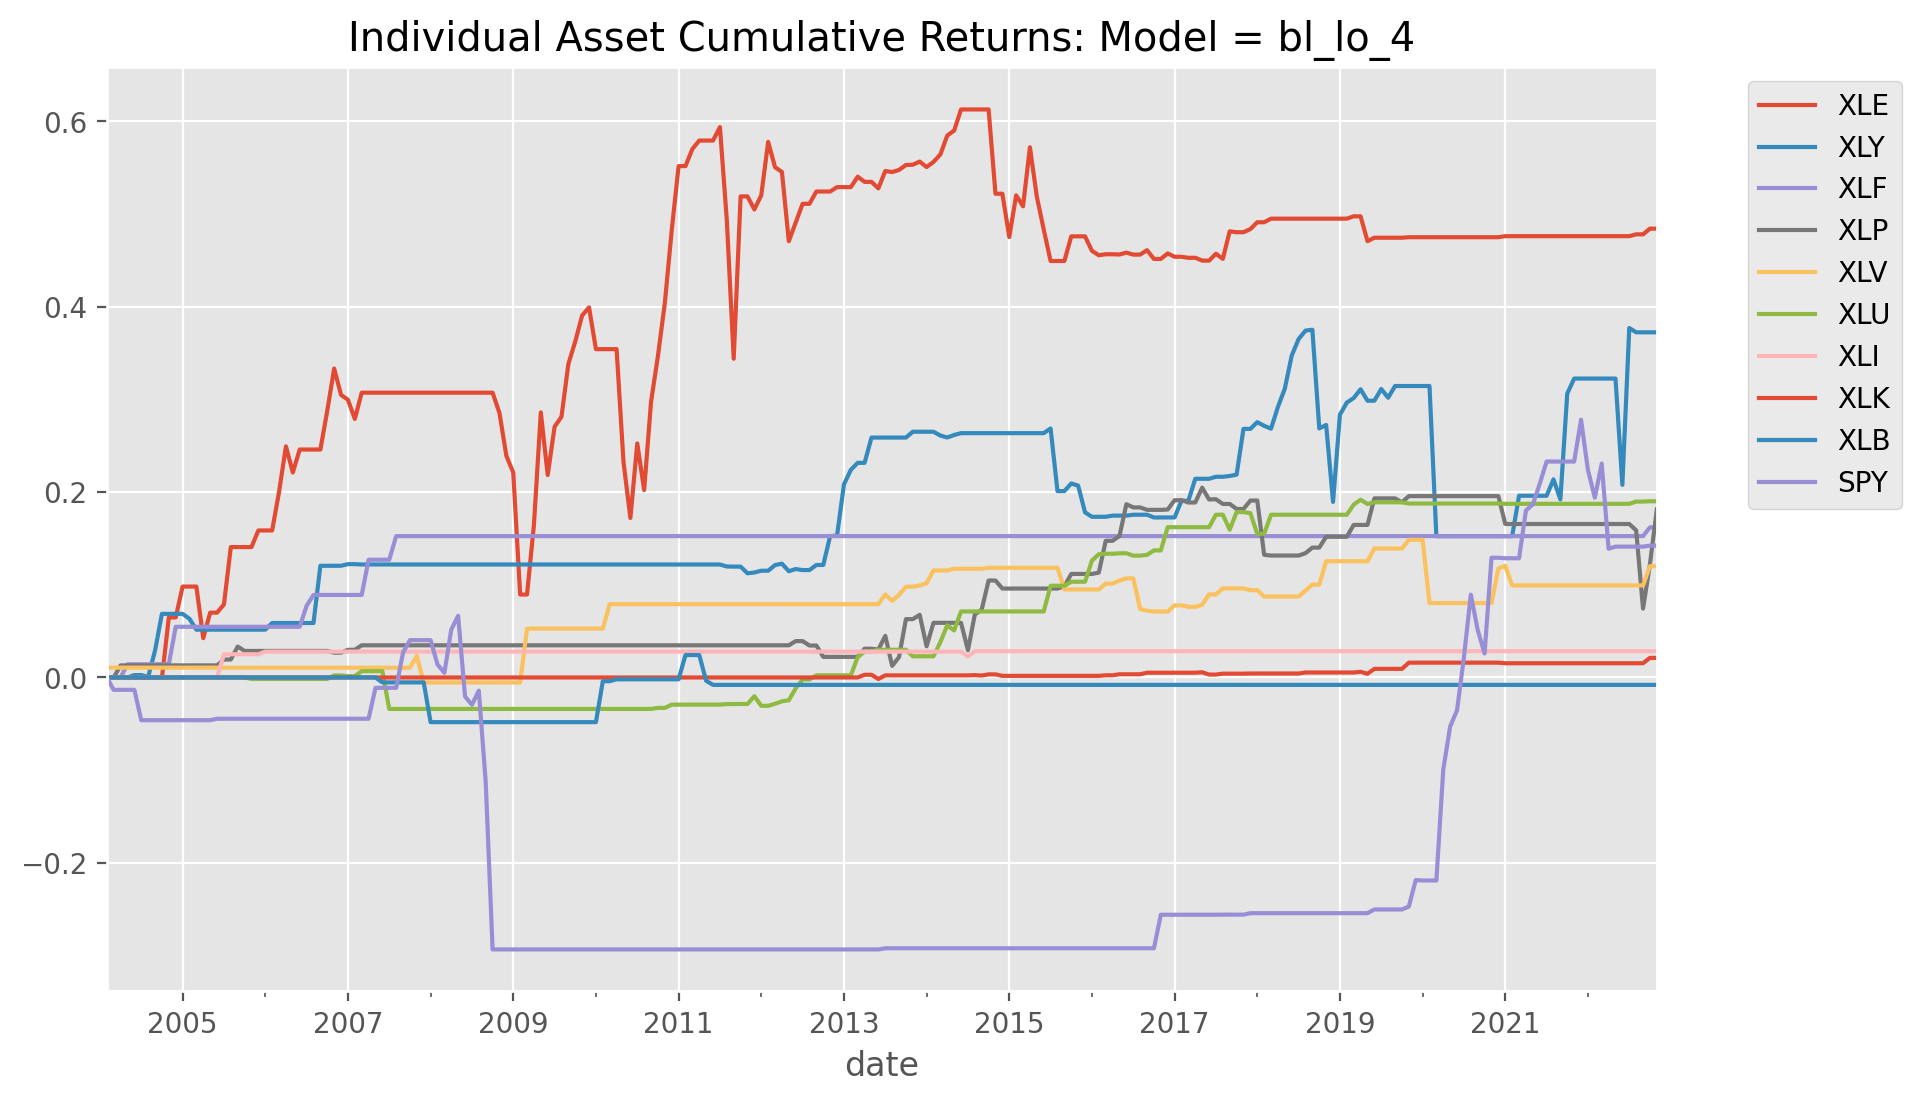

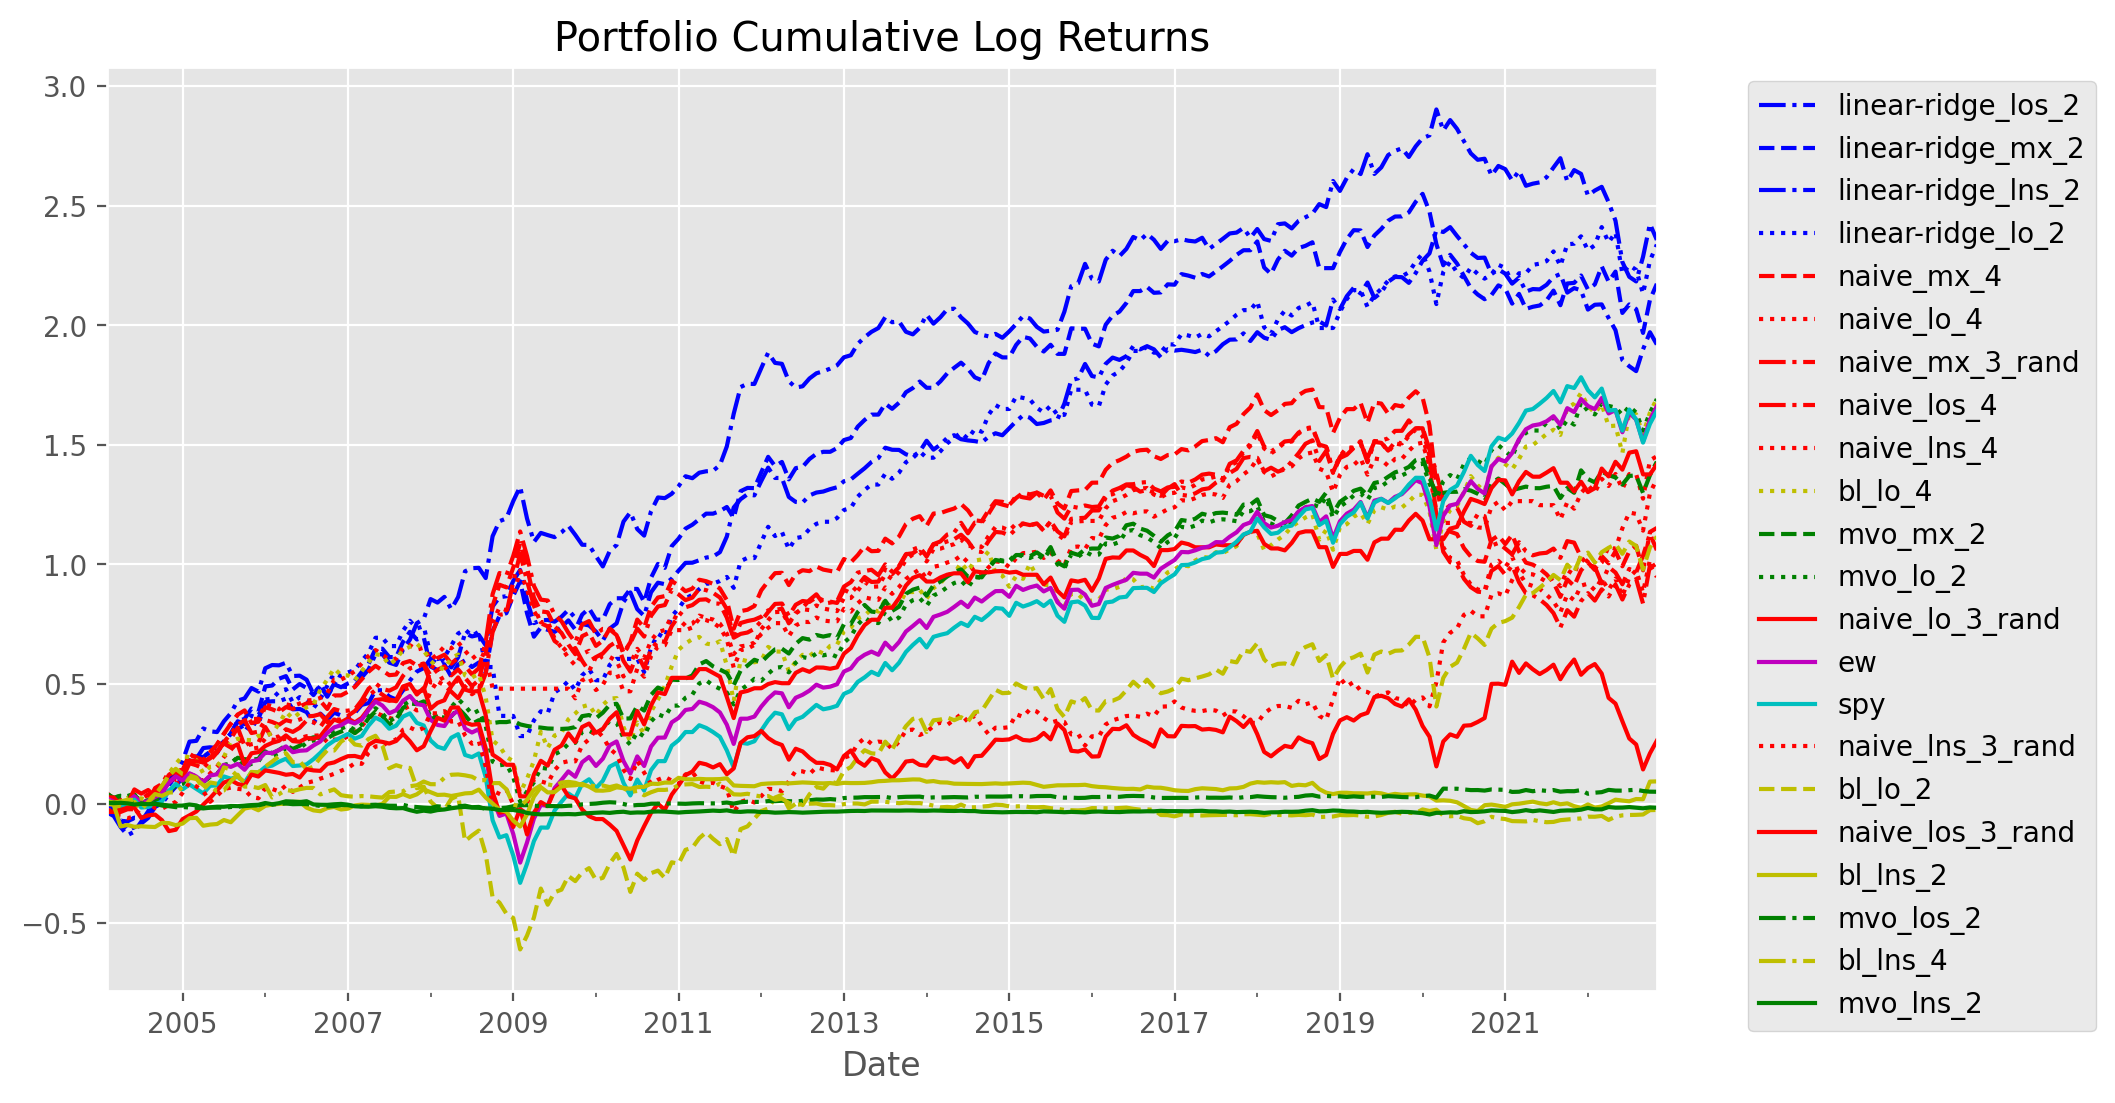

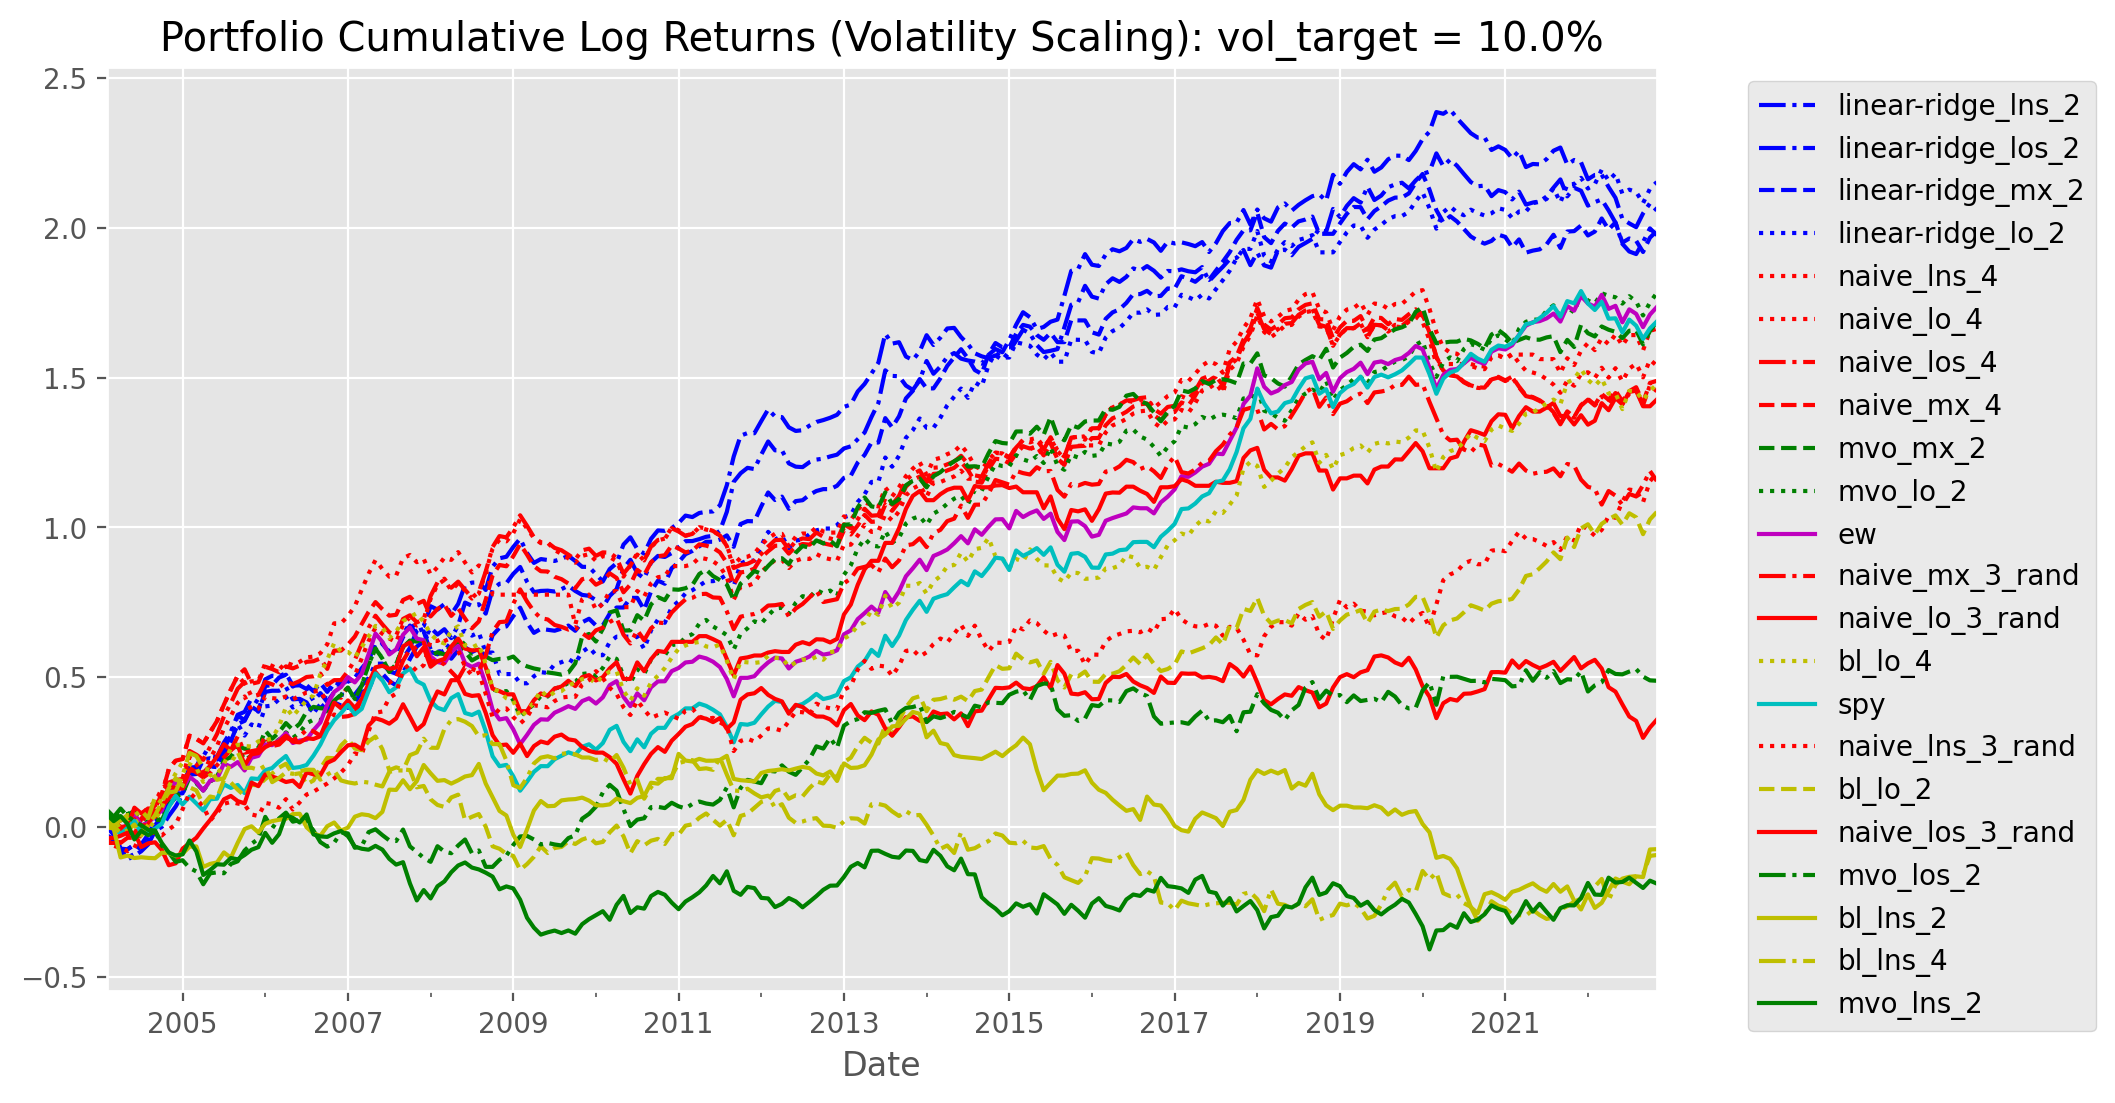

In [13]:
%config InlineBackend.figure_format = 'retina'
equal_weight_cumm_returns = pd.DataFrame(returns.mean(axis=1), columns=["ew"])
spy_cumm_returns = pd.DataFrame(pd.DataFrame(returns['SPY'], columns=["SPY"]).sum(axis=1), columns=["spy"])
concat_list = [equal_weight_cumm_returns, spy_cumm_returns]

model_list = all_portfolio_returns_df["models"].unique()
model_list = [
    'naive_los_3_rand', 
    'naive_mx_4',
    #'naive_los_3',
    'naive_lns_3_rand',
    #'naive_lns_2',
    #'naive_mx_3',
    #'naive_lns_3',
    #'naive_mx_2',
    #'naive_los_2',
    #'naive_lo_2',
    'naive_mx_3_rand',
    'naive_lns_4',
    'naive_lo_3_rand',
    #'naive_lo_3',
    'naive_los_4',
    'naive_lo_4',
    #'linear-ridge_mx_4',
    #'linear-ridge_los_3',
    'linear-ridge_lns_2',
    #'linear-ridge_mx_3',
    #'linear-ridge_lns_3',
    'linear-ridge_mx_2',
    'linear-ridge_los_2',
    'linear-ridge_lo_2',
    #'linear-ridge_lns_4',
    #'linear-ridge_lo_3',
    #'linear-ridge_los_4',
    #'linear-ridge_lo_4',
    'mvo_lns_2',
    'mvo_lo_2',
    'mvo_los_2',
    'mvo_mx_2',
    'bl_lns_2',
    'bl_lo_2',
    'bl_lns_4',
    'bl_lo_4',
]
print(style_map)
styles = ['m', 'c'] + [style_map[model] for model in model_list]
for model in model_list:
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")
    order = tmp_portfolio_returns.cumsum().mean(axis=0).sort_values(ascending=False).index
    ax = tmp_portfolio_returns.cumsum()[order].plot(figsize=(10, 6), title=f"Individual Asset Cumulative Returns: Model = {model}")
    
    # Place the legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

    # add equal weight
    concat_list.append(pd.DataFrame(tmp_portfolio_returns.sum(axis=1), columns=[model]))

cumm_returns_plot = pd.concat(concat_list, axis=1)
order = cumm_returns_plot.cumsum().mean(axis=0).sort_values(ascending=False).index
order_style = list(cumm_returns_plot.cumsum().mean(axis=0).argsort())
ax = cumm_returns_plot.cumsum()[order].plot(figsize=(10, 6), style=[styles[x] for x in reversed(order_style)], title="Portfolio Cumulative Log Returns", xlabel="Date")

# Place the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (cumm_returns_plot.rolling(window=12).std().bfill() * np.sqrt(12))
cumm_returns_plot = (cumm_returns_plot * portfolio_vol).dropna()
order = cumm_returns_plot.cumsum().mean(axis=0).sort_values(ascending=False).index
order_style = list(cumm_returns_plot.cumsum().mean(axis=0).argsort())
ax = cumm_returns_plot.cumsum()[order].plot(figsize=(10, 6), style=[styles[x] for x in reversed(order_style)], title=f"Portfolio Cumulative Log Returns (Volatility Scaling): vol_target = {vol_target * 100}%", xlabel="Date")

# Place the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [8]:
# ew_vol_scale = 10 / (equal_weight_cumm_returns.rolling(window=3).std() * 12 * 100)
# tensor_scaled_equal_weight_cumm_returns = torch.tensor((equal_weight_cumm_returns * ew_vol_scale).dropna().values)
ew_summary_statistics = compute_summary_statistics(torch.tensor(equal_weight_cumm_returns.values))
ew_summary_statistics = pd.DataFrame([ew_summary_statistics], index=["EW"])

all_summary_statistics = []
for model in all_portfolio_returns_df["models"].unique():
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")

    vol_scale = 10 / (tmp_portfolio_returns.mean(axis=1).rolling(window=3).std() * 12 * 100)
    tensor_tmp_portfolio_returns = torch.tensor((tmp_portfolio_returns.mean(axis=1) * vol_scale).dropna().values)
    summary_statistics = compute_summary_statistics(tensor_tmp_portfolio_returns)
    summary_statistics = pd.DataFrame([summary_statistics], index=[model])

    all_summary_statistics.append(summary_statistics)
all_summary_statistics_df = pd.concat(all_summary_statistics)

all_summary_statistics_df

E[R]     Std(R)    Sharpe   Sortino      AvgDD  \
naive_los_3_rand    1.083307  18.733543  0.200319  0.386703  -6.525560   
naive_mx_4          3.677039  17.067149  0.746325  1.485978  -3.897023   
naive_los_3         5.273663  32.156573  0.568111  2.356949  -3.214385   
naive_lns_3_rand    3.273567  17.857445  0.635027  1.657378  -3.104660   
naive_lns_2         4.838992  25.736531  0.651322  1.983899  -4.162020   
naive_mx_3          4.293688  20.105569  0.739784  1.948415  -3.134988   
naive_lns_3         8.884642  76.646072  0.401551  3.532935  -3.545313   
naive_mx_2          3.952692  17.710388  0.773135  1.771322  -3.524086   
naive_los_2         3.979019  17.315257  0.796045  1.742465  -3.900600   
naive_lo_2          4.938523  16.924918  1.010790  2.675754  -1.431569   
naive_mx_3_rand     4.275944  19.457613  0.761260  1.169512  -3.300049   
naive_lns_4         3.430283  16.189683  0.733977  1.206821  -4.232176   
naive_lo_3_rand     3.623587  12.668146  0.990869  1.885621  -1.232193   
naive_lo_3          5.197401  19.637929  0.916814  2.729397  -1.341761   
naive_los_4         4.032058  17.718271  0.788308  1.618071  -3.438880   
naive_lo_4          5.103780  16.111356  1.097363  2.684347  -1.387076   
linear-ridge_mx_4   5.176032  13.756516  1.303404  2.553603  -1.672878   
linear-ridge_los_3  6.830945  22.516905  1.050903  3.322305  -1.555390   
linear-ridge_lns_2  5.629180  29.269987  0.666213  0.717884  -3.668038   
linear-ridge_mx_3   5.050532  13.159195  1.329531  2.673733  -1.402705   
linear-ridge_lns_3  6.205573  22.568562  0.952508  2.976853  -1.815653   
linear-ridge_mx_2   6.966313  23.772933  1.015105  2.864523  -1.786157   
linear-ridge_los_2  6.296758  24.914137  0.875511  2.126733  -1.722247   
linear-ridge_lo_2   7.701357  23.460989  1.137134  4.468773  -0.678186   
linear-ridge_lns_4  6.443998  23.106664  0.966070  3.067465  -2.026024   
linear-ridge_lo_3   5.652978  12.976128  1.509117  3.184031  -0.703116   
linear-ridge_los_4  6.184933  19.947408  1.074086  2.812772  -1.863024   
linear-ridge_lo_4   5.752189  13.338583  1.493874  3.215696  -0.706506   
mvo_lns_2           0.682284  16.461197  0.143580  0.239958  -7.384164   
mvo_mx_2            3.239896  12.490901  0.898521  1.452162  -1.255527   
mvo_los_2           0.161121  18.838005  0.029628  0.026806  -9.041754   
mvo_lo_2            4.065356  12.887408  1.092757  1.945504  -0.921463   
bl_lns_2            0.261067  15.431989  0.058603  0.075569  -7.363539   
bl_lo_2             5.454945  19.181500  0.985141  3.271994  -1.631810   
bl_lns_4           -0.268938  12.270971 -0.075921 -0.109663 -11.250440   
bl_lo_4             5.840683  16.961697  1.192848  3.131243  -1.367567   

                        MaxDD  % Positive Ret.  
naive_los_3_rand   -16.700878         0.504464  
naive_mx_4         -17.807080         0.589286  
naive_los_3        -14.772553         0.558036  
naive_lns_3_rand   -11.763909         0.535714  
naive_lns_2        -14.941776         0.580357  
naive_mx_3         -14.680858         0.575893  
naive_lns_3        -16.148244         0.558036  
naive_mx_2         -14.642661         0.584821  
naive_los_2        -14.595108         0.580357  
naive_lo_2          -6.162702         0.570755  
naive_mx_3_rand    -17.138601         0.607143  
naive_lns_4        -17.699095         0.580357  
naive_lo_3_rand     -5.744910         0.533632  
naive_lo_3          -5.858757         0.556604  
naive_los_4        -17.064206         0.580357  
naive_lo_4          -6.719434         0.580189  
linear-ridge_mx_4  -10.469553         0.589286  
linear-ridge_los_3 -10.975798         0.620536  
linear-ridge_lns_2 -27.019573         0.620536  
linear-ridge_mx_3   -7.795270         0.598214  
linear-ridge_lns_3 -13.266446         0.593750  
linear-ridge_mx_2  -12.300005         0.611607  
linear-ridge_los_2  -9.925835         0.620536  
linear-ridge_lo_2   -4.389199         0.609865  
linear-ridge_lns_4 -14.089936         0.580357  
linear-ridg

In [9]:
groups_summary = all_summary_statistics_df.reset_index()
groups_summary["model"] = groups_summary["index"].apply(lambda x: x.split("_")[0])
groups_summary["type"] = groups_summary["index"].apply(lambda x: x.split("_")[1])
groups_summary["num_assets"] = groups_summary["index"].apply(lambda x: x.split("_")[2])
groups_summary["random tag"] = groups_summary["index"].apply(lambda x: x.split("_")[3] if len(x.split("_")) > 3 else None)

del groups_summary["index"]

In [10]:
tmp_df = groups_summary.loc[groups_summary["type"] == "lo"][["model", "num_assets", "random tag", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]].round(3)

out_one = pd.concat([tmp_df, ew_summary_statistics.round(3)])
for row in out_one.iterrows():
    cur_dict = row[1].to_dict()
    out_str = f"{cur_dict['model']} (l = {cur_dict['num_assets']})    "
    for key in ['Sharpe', 'Sortino', 'AvgDD', 'MaxDD', '% Positive Ret.']:
        out_str += "%.3f" % (cur_dict[key])
        out_str += " & "
    print(out_str[:-3])

pd.concat([tmp_df, ew_summary_statistics.round(3)])

naive (l = 2)    1.011 & 2.676 & -1.432 & -6.163 & 0.571
naive (l = 3)    0.991 & 1.886 & -1.232 & -5.745 & 0.534
naive (l = 3)    0.917 & 2.729 & -1.342 & -5.859 & 0.557
naive (l = 4)    1.097 & 2.684 & -1.387 & -6.719 & 0.580
linear-ridge (l = 2)    1.137 & 4.469 & -0.678 & -4.389 & 0.610
linear-ridge (l = 3)    1.509 & 3.184 & -0.703 & -4.386 & 0.596
linear-ridge (l = 4)    1.494 & 3.216 & -0.707 & -4.368 & 0.596
mvo (l = 2)    1.093 & 1.946 & -0.921 & -6.833 & 0.616
bl (l = 2)    0.985 & 3.272 & -1.632 & -11.026 & 0.616
bl (l = 4)    1.193 & 3.131 & -1.368 & -10.402 & 0.625
nan (l = nan)    0.589 & 0.697 & -5.885 & -50.183 & 0.664


model num_assets random tag  Sharpe  Sortino  AvgDD   MaxDD  \
9          naive          2       None   1.011    2.676 -1.432  -6.163   
12         naive          3       rand   0.991    1.886 -1.232  -5.745   
13         naive          3       None   0.917    2.729 -1.342  -5.859   
15         naive          4       None   1.097    2.684 -1.387  -6.719   
23  linear-ridge          2       None   1.137    4.469 -0.678  -4.389   
25  linear-ridge          3       None   1.509    3.184 -0.703  -4.386   
27  linear-ridge          4       None   1.494    3.216 -0.707  -4.368   
31           mvo          2       None   1.093    1.946 -0.921  -6.833   
33            bl          2       None   0.985    3.272 -1.632 -11.026   
35            bl          4       None   1.193    3.131 -1.368 -10.402   
EW           NaN        NaN        NaN   0.589    0.697 -5.885 -50.183   

    % Positive Ret.   E[R]  Std(R)  
9             0.571    NaN     NaN  
12            0.534    NaN     NaN  
13            0.557    NaN     NaN  
15            0.580    NaN     NaN  
23            0.610    NaN     NaN  
25            0.596    NaN     NaN  
27            0.596    NaN     NaN  
31            0.616    NaN     NaN  
33            0.616    NaN     NaN  
35            0.625    NaN     NaN  
EW            0.664  8.822  51.849

In [ ]:
tmp_df = groups_summary.loc[groups_summary["type"] == "mx"][["model", "num_assets", "random tag", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]].round(3)

out_one = pd.concat([tmp_df, ew_summary_statistics.round(3)])
for row in out_one.iterrows():
    cur_dict = row[1].to_dict()
    out_str = f"{cur_dict['model']} (l = {cur_dict['num_assets']})    "
    for key in ['Sharpe', 'Sortino', 'AvgDD', 'MaxDD', '% Positive Ret.']:
        out_str += "%.3f" % (cur_dict[key])
        out_str += " & "
    print(out_str[:-3])

pd.concat([tmp_df, ew_summary_statistics.round(3)])

naive (l = 4)    0.746 & 1.486 & -3.897 & -17.807 & 0.589
naive (l = 3)    0.740 & 1.948 & -3.135 & -14.681 & 0.576
naive (l = 2)    0.773 & 1.771 & -3.524 & -14.643 & 0.585
naive (l = 3)    0.761 & 1.170 & -3.300 & -17.139 & 0.607
linear-ridge (l = 4)    1.303 & 2.554 & -1.673 & -10.470 & 0.589
linear-ridge (l = 3)    1.330 & 2.674 & -1.403 & -7.795 & 0.598
linear-ridge (l = 2)    1.015 & 2.865 & -1.786 & -12.300 & 0.612
mvo (l = 2)    0.899 & 1.452 & -1.256 & -6.737 & 0.598
nan (l = nan)    0.589 & 0.697 & -5.885 & -50.183 & 0.664


model num_assets random tag  Sharpe  Sortino  AvgDD   MaxDD  \
1          naive          4       None   0.746    1.486 -3.897 -17.807   
5          naive          3       None   0.740    1.948 -3.135 -14.681   
7          naive          2       None   0.773    1.771 -3.524 -14.643   
10         naive          3       rand   0.761    1.170 -3.300 -17.139   
16  linear-ridge          4       None   1.303    2.554 -1.673 -10.470   
19  linear-ridge          3       None   1.330    2.674 -1.403  -7.795   
21  linear-ridge          2       None   1.015    2.865 -1.786 -12.300   
29           mvo          2       None   0.899    1.452 -1.256  -6.737   
EW           NaN        NaN        NaN   0.589    0.697 -5.885 -50.183   

    % Positive Ret.   E[R]  Std(R)  
1             0.589    NaN     NaN  
5             0.576    NaN     NaN  
7             0.585    NaN     NaN  
10            0.607    NaN     NaN  
16            0.589    NaN     NaN  
19            0.598    NaN     NaN  
21            0.612    NaN     NaN  
29            0.598    NaN     NaN  
EW            0.664  8.822  51.849

In [12]:
tmp_df = groups_summary.loc[groups_summary["type"] == "los"][["model", "num_assets", "random tag", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]].round(3)

out_one = pd.concat([tmp_df, ew_summary_statistics.round(3)])
for row in out_one.iterrows():
    cur_dict = row[1].to_dict()
    out_str = f"{cur_dict['model']} (l = {cur_dict['num_assets']})    "
    for key in ['Sharpe', 'Sortino', 'AvgDD', 'MaxDD', '% Positive Ret.']:
        out_str += "%.3f" % (cur_dict[key])
        out_str += " & "
    print(out_str[:-3])

pd.concat([tmp_df, ew_summary_statistics.round(3)])

naive (l = 3)    0.200 & 0.387 & -6.526 & -16.701 & 0.504
naive (l = 3)    0.568 & 2.357 & -3.214 & -14.773 & 0.558
naive (l = 2)    0.796 & 1.742 & -3.901 & -14.595 & 0.580
naive (l = 4)    0.788 & 1.618 & -3.439 & -17.064 & 0.580
linear-ridge (l = 3)    1.051 & 3.322 & -1.555 & -10.976 & 0.621
linear-ridge (l = 2)    0.876 & 2.127 & -1.722 & -9.926 & 0.621
linear-ridge (l = 4)    1.074 & 2.813 & -1.863 & -13.546 & 0.598
mvo (l = 2)    0.030 & 0.027 & -9.042 & -24.933 & 0.522
nan (l = nan)    0.589 & 0.697 & -5.885 & -50.183 & 0.664


model num_assets random tag  Sharpe  Sortino  AvgDD   MaxDD  \
0          naive          3       rand   0.200    0.387 -6.526 -16.701   
2          naive          3       None   0.568    2.357 -3.214 -14.773   
8          naive          2       None   0.796    1.742 -3.901 -14.595   
14         naive          4       None   0.788    1.618 -3.439 -17.064   
17  linear-ridge          3       None   1.051    3.322 -1.555 -10.976   
22  linear-ridge          2       None   0.876    2.127 -1.722  -9.926   
26  linear-ridge          4       None   1.074    2.813 -1.863 -13.546   
30           mvo          2       None   0.030    0.027 -9.042 -24.933   
EW           NaN        NaN        NaN   0.589    0.697 -5.885 -50.183   

    % Positive Ret.   E[R]  Std(R)  
0             0.504    NaN     NaN  
2             0.558    NaN     NaN  
8             0.580    NaN     NaN  
14            0.580    NaN     NaN  
17            0.621    NaN     NaN  
22            0.621    NaN     NaN  
26            0.598    NaN     NaN  
30            0.522    NaN     NaN  
EW            0.664  8.822  51.849

In [ ]:
tmp_df = groups_summary.loc[groups_summary["type"] == "lns"][["model", "num_assets", "random tag", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]].round(3)

out_one = pd.concat([tmp_df, ew_summary_statistics.round(3)])
for row in out_one.iterrows():
    cur_dict = row[1].to_dict()
    out_str = f"{cur_dict['model']} (l = {cur_dict['num_assets']})    "
    for key in ['Sharpe', 'Sortino', 'AvgDD', 'MaxDD', '% Positive Ret.']:
        out_str += "%.3f" % (cur_dict[key])
        out_str += " & "
    print(out_str[:-3])

pd.concat([tmp_df, ew_summary_statistics.round(3)])

model num_assets random tag  Sharpe  Sortino   AvgDD   MaxDD  \
3          naive          3       rand   0.635    1.657  -3.105 -11.764   
4          naive          2       None   0.651    1.984  -4.162 -14.942   
6          naive          3       None   0.402    3.533  -3.545 -16.148   
11         naive          4       None   0.734    1.207  -4.232 -17.699   
18  linear-ridge          2       None   0.666    0.718  -3.668 -27.020   
20  linear-ridge          3       None   0.953    2.977  -1.816 -13.266   
24  linear-ridge          4       None   0.966    3.067  -2.026 -14.090   
28           mvo          2       None   0.144    0.240  -7.384 -16.321   
30            bl          2       None   0.059    0.076  -7.364 -23.050   
32            bl          4       None  -0.076   -0.110 -11.250 -22.394   

    % Positive Ret.  
3             0.536  
4             0.580  
6             0.558  
11            0.580  
18            0.621  
20            0.594  
24            0.580  
28            0.473  
30            0.518  
32            0.491